In [1]:
from utils import *
from ISM import *

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
font = {# 'family' : 'serif', # Times (source: https://matplotlib.org/tutorials/introductory/customizing.html)
        'family': 'sans-serif', # Helvetica
#         'family': 'monospace',
#         'weight' : 'bold',
        'size'   : 12}
matplotlib.rc('font', **font) 
text = {'usetex': False}
matplotlib.rc('text', **text)
monospace_font = {'fontname':'monospace'}

GISAID_DATA_DATE = '20200617'
print('This report covers GISAID data downloaded in: {}'.format(GISAID_DATA_DATE))

This report covers GISAID data downloaded in: 20200617


In [2]:
output_folder = '20200617_REVISION_SHORT'

In [3]:
REFERENCE_ISM = 'CCACCCGCCCACAAGGTGGG'

In [4]:
ISM_df = pd.read_csv('{}/IMS_20nt_with_correction.csv'.format('results_20200617'))
ISM_df['date'] = pd.to_datetime(ISM_df['date'])

In [5]:
tmp = ISM_df[['ISM','ISM_compressed', 'gisaid_epi_isl']].groupby(['ISM','ISM_compressed'])['gisaid_epi_isl'].nunique().reset_index(name = 'count')


In [6]:
long_to_short = {}
for i in range(tmp.shape[0]):
    long, short, count = tmp.iloc[i]['ISM'], tmp.iloc[i]['ISM_compressed'], tmp.iloc[i]['count']
    if long in long_to_short:
        print(long, short, count)
    else:
        long_to_short[long] = short

In [7]:
long_to_short['CCACCTGCTCACAAGGCGGG']

'CCTGTCAAGGG'

In [10]:
from sklearn.externals import joblib
short_to_long = joblib.load('{}/compressed_to_ISM.joblib'.format('20200617_REVISION'))

In [11]:
REFERENCE_ISM = ISM_df[ISM_df['ISM'] == REFERENCE_ISM]['ISM_compressed'].value_counts().keys()[0]

In [12]:
ISM_df['ISM'] = ISM_df['ISM_compressed']

In [13]:
print('Unique ISMs after error correction: {}'.format(ISM_df['ISM'].unique().shape[0]))

Unique ISMs after error correction: 498


In [14]:
ISM_index = {}
idx = 0
for ISM, counts in ISM_df['ISM'].value_counts().items():
    ISM_index[ISM] = idx
    idx += 1
K = 20
key_list = []
value_list = []
for ISM, counts in ISM_df['ISM'].value_counts().items():
    key_list.append(ISM)
    value_list.append(counts)
top_key_list = key_list[:K]
top_value_list = value_list[:K]

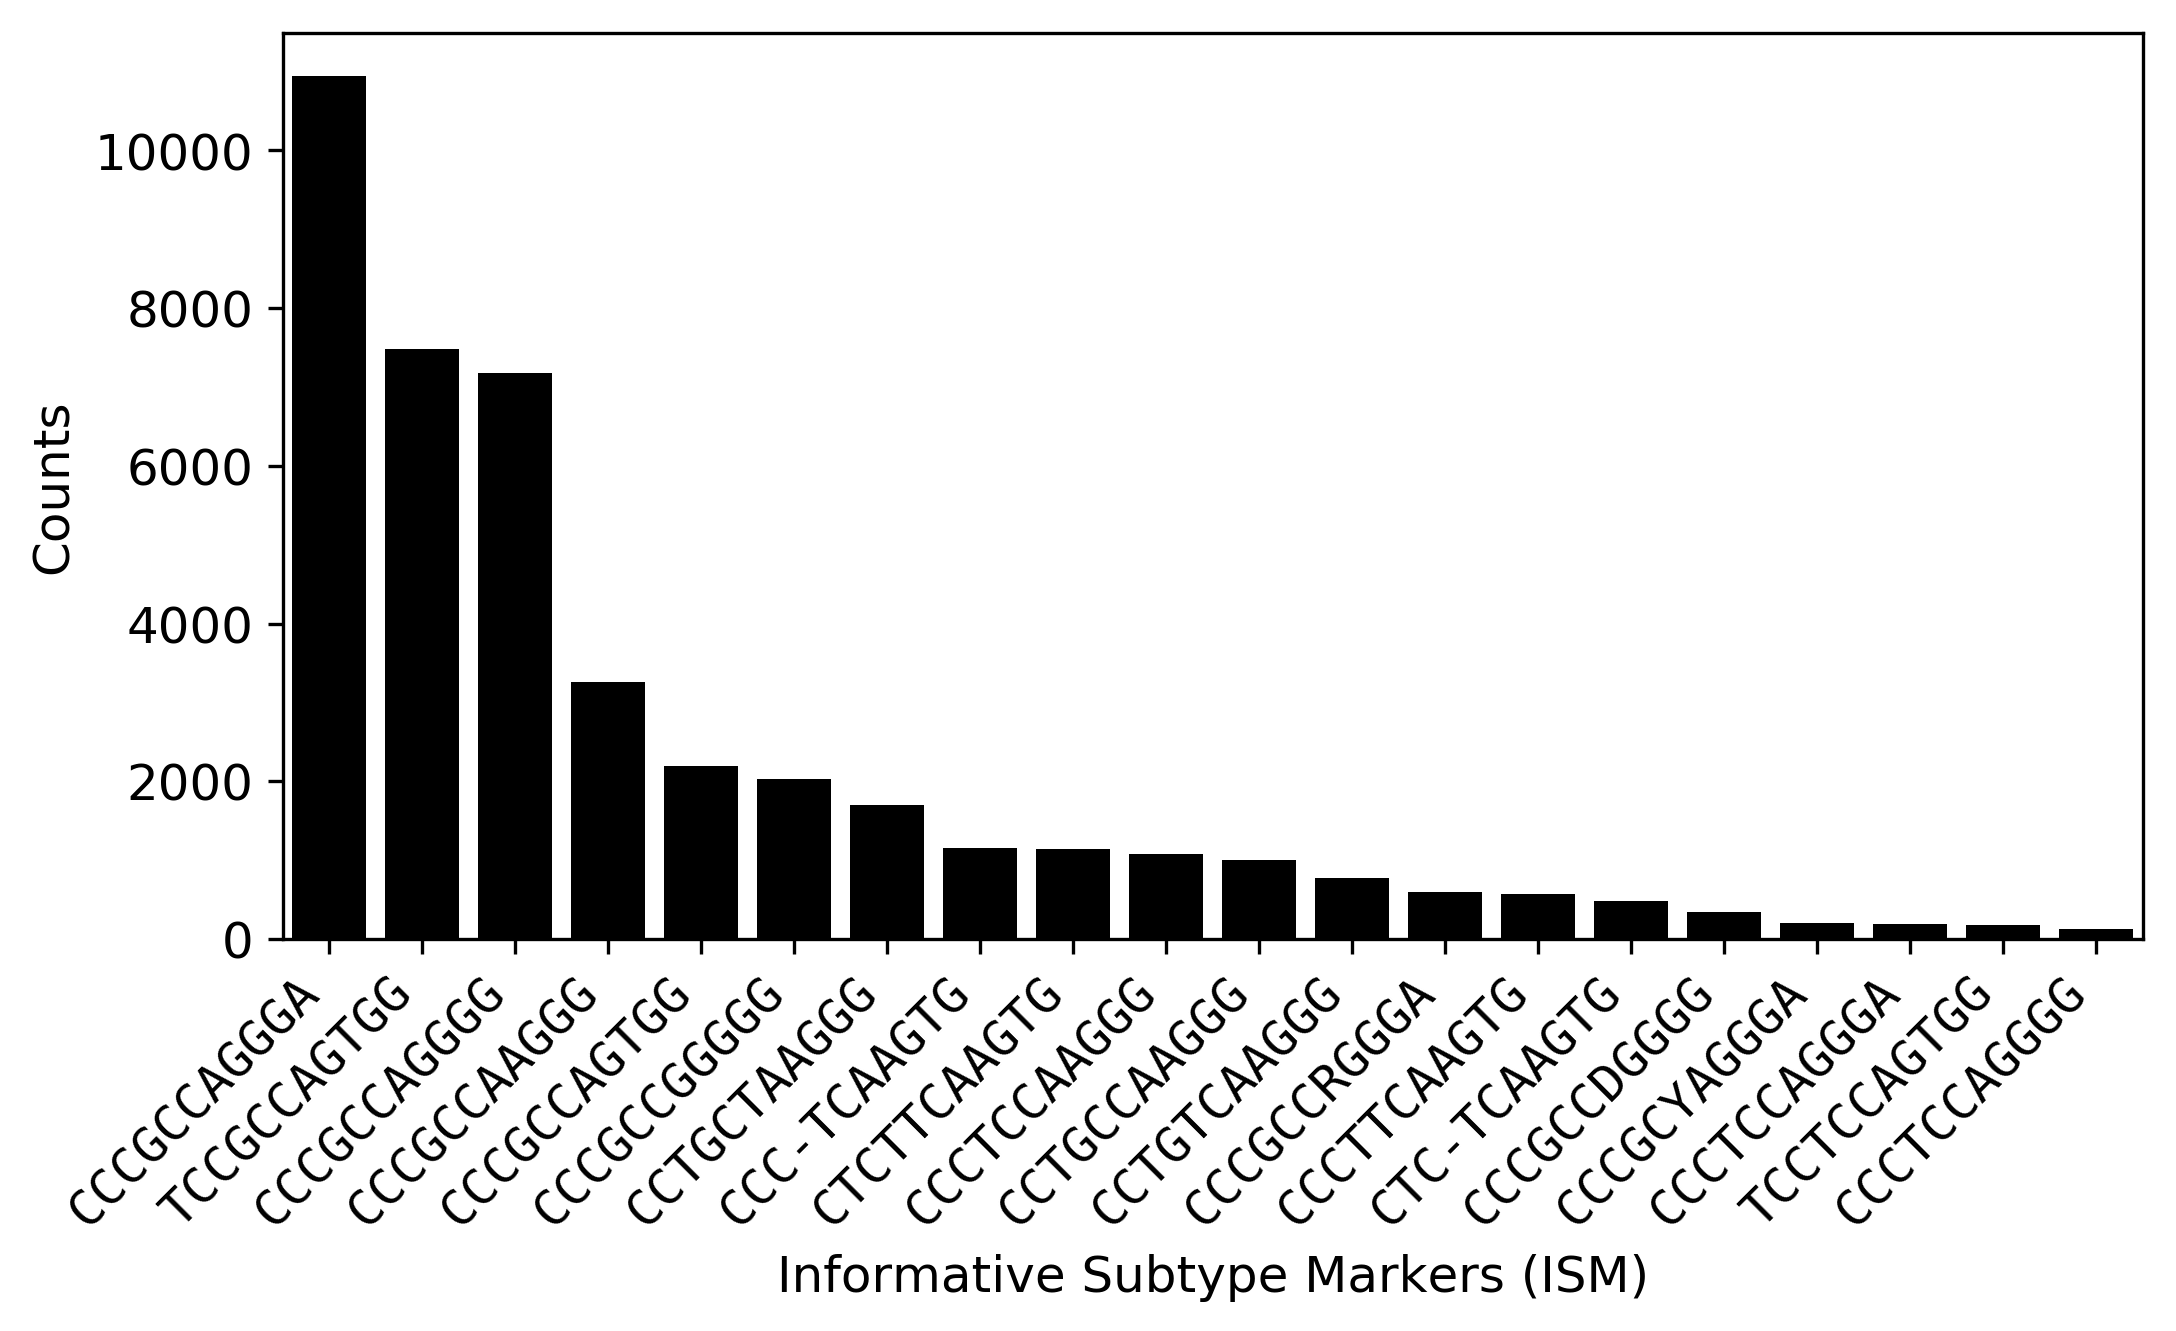

In [15]:
DPI = 300
fig = plt.figure(figsize=(2400/DPI, 1200/DPI), dpi=DPI)   

x = np.arange(len(top_key_list))

plt.bar(x, top_value_list, color = 'black')
# plt.xticks(x, top_key_list, rotation = -45, ha='left',**monospace_font)
plt.xticks(x, top_key_list, rotation = 45, ha='right',**monospace_font)
plt.xlabel('Informative Subtype Markers (ISM)')
plt.ylabel('Counts')
plt.xlim([-0.5, len(top_value_list)-0.5])
plt.savefig('{}/4_ISM_histogram_short.pdf'.format(output_folder), bbox_inches='tight', dpi=DPI)
plt.show()

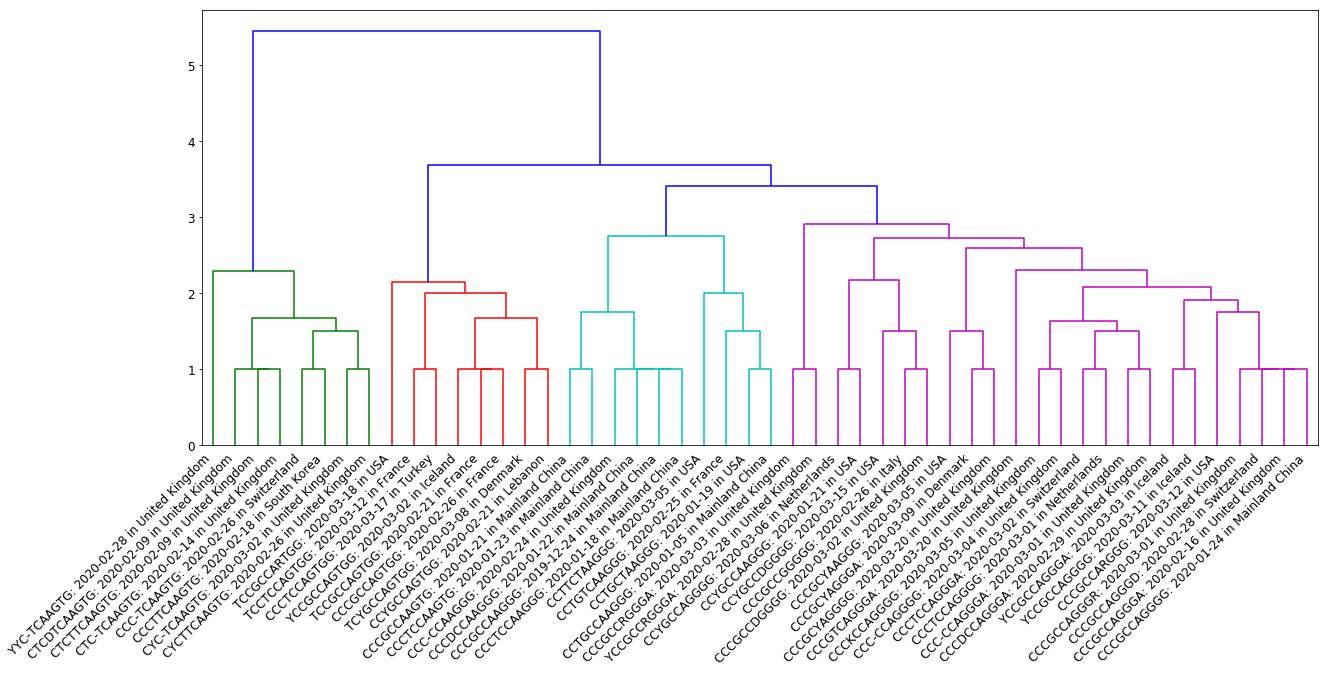

In [16]:
def hamming_dist(str1, str2):
    # assuming same length
    d = 0
    for i in range(len(str1)):
        if str1[i] == str2[i]:
            continue
        d += 1
    return d

K = 50
key_list = []
value_list = []
for ISM, counts in ISM_df['ISM'].value_counts().items():
    key_list.append(ISM)
    value_list.append(counts)
top_key_list = key_list[:K]
top_value_list = value_list[:K]

ISM_country = {}
for ISM in top_key_list:
    temp = ISM_df[ISM_df['ISM'] == ISM].groupby(['country/region']).agg({'date': 'min'}).reset_index()
    ISM_country[ISM] = '{} in {}'.format(str(temp['date'].min().date()), temp.iloc[temp['date'].idxmin()]['country/region'])

dated_label = ['{}: {}'.format(ISM, ISM_country[ISM]) for ISM in top_key_list[:K]]

ISM_hamming_dist = []
for i in range(K):
    for j in range(i + 1, K):
        ISM1 = top_key_list[i]
        ISM2 = top_key_list[j]
        d = hamming_dist(ISM1, ISM2)
        ISM_hamming_dist.append(d)
from scipy.cluster.hierarchy import dendrogram, linkage

font = {# 'family' : 'serif', # Times (source: https://matplotlib.org/tutorials/introductory/customizing.html)
        'family': 'sans-serif', # Helvetica
#         'family': 'monospace',
#         'weight' : 'bold',
        'size'   : 12}
matplotlib.rc('font', **font) 

linked = linkage(ISM_hamming_dist, 'average')

fig, ax = plt.subplots(figsize=(20,8))
dendrogram(linked,
            orientation='top',
            labels=dated_label,
            distance_sort='descending',
            color_threshold=3,
            leaf_font_size=12,
            show_leaf_counts=True)
plt.setp(ax.get_xticklabels(), ha='right', rotation=45)
plt.savefig('{}/4_top_ISM_tree_short.pdf'.format(output_folder), bbox_inches='tight')
plt.show()

In [17]:
ISM_dist_time = []
REFERENCE_date = ISM_df[ISM_df['ISM'] == REFERENCE_ISM]['date'].min().date()
max_date = REFERENCE_date
for i in range(K):
    ISM = top_key_list[i]
    d = hamming_dist(REFERENCE_ISM, ISM)
    ISM_date = ISM_df[ISM_df['ISM'] == ISM]['date'].min().date()
    if ISM_date > max_date:
        max_date = ISM_date
    delta = ISM_date - REFERENCE_date
    ISM_dist_time.append((d, abs(delta.days)))

In [18]:
#!wget -O data/total_cases_20200621.csv https://covid.ourworldindata.org/data/ecdc/total_cases.csv

In [19]:
total_cases_df = pd.read_csv('data/total_cases_20200621.csv')
total_cases_df['date'] = pd.to_datetime(total_cases_df['date'])
world_date = total_cases_df[(total_cases_df['date'] >= REFERENCE_date) & (total_cases_df['date'] <= max_date)]['date']
world_cases = total_cases_df[(total_cases_df['date'] >= REFERENCE_date) & (total_cases_df['date'] <= max_date)]['World'].values
world_cases_time = []
for i in range(world_date.shape[0]):
    delta = world_date.iloc[i].date() - REFERENCE_date
    world_cases_time.append((world_cases[i], abs(delta.days)))

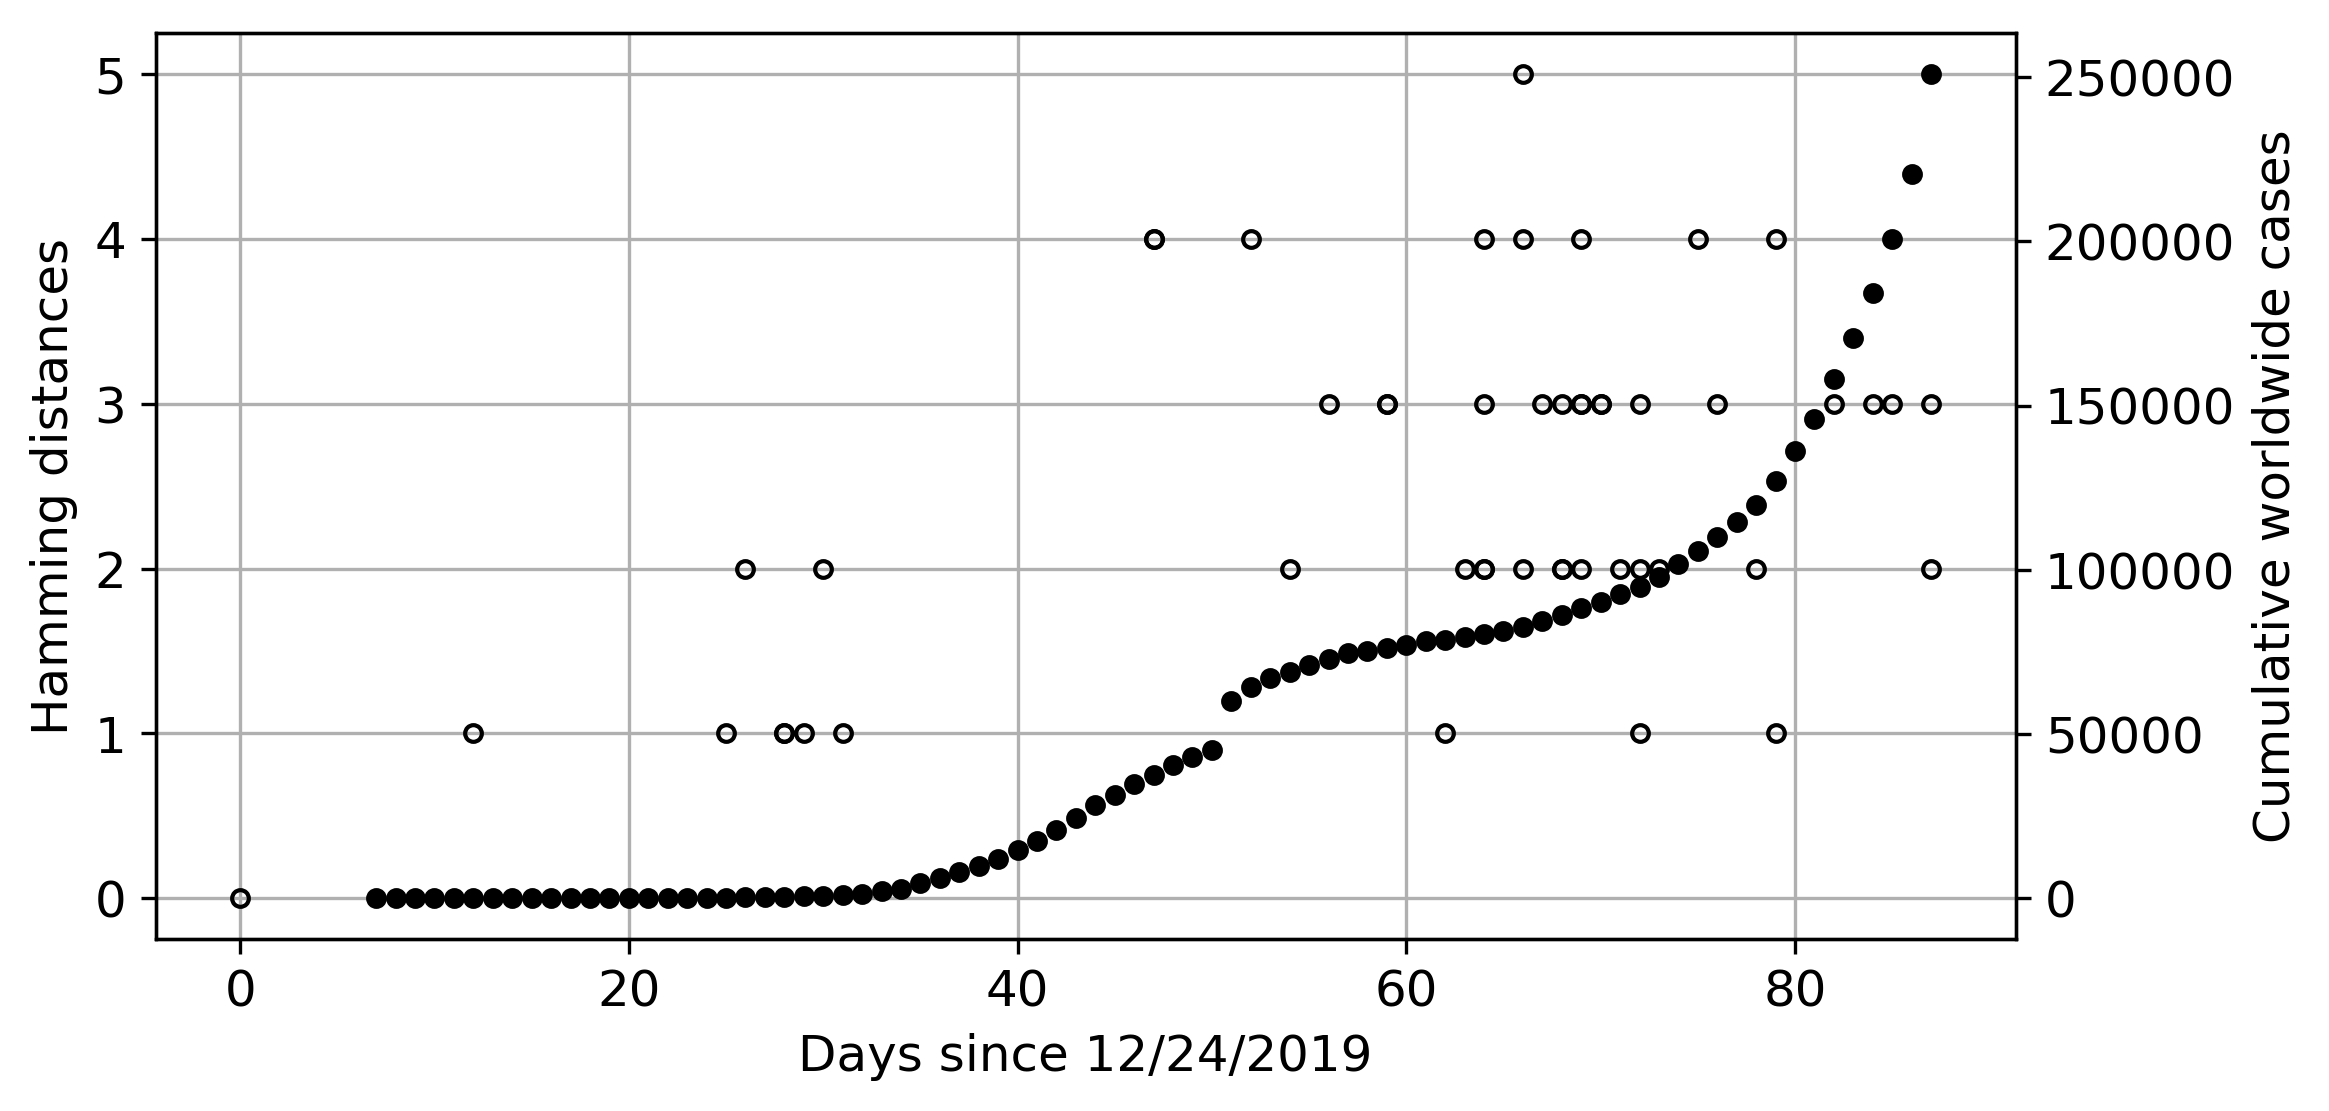

In [20]:
from scipy.stats import pearsonr
# corr, _ = pearsonr(np.array(ISM_time_difference)/np.max(ISM_time_difference), np.array(ISM_hamming_dist)/np.max(ISM_hamming_dist))
# title = 'Pearsons correlation: {:.3f}'.format(corr)
fig, ax1 = plt.subplots(figsize=(2400/DPI, 1200/DPI), dpi=DPI)
plt.grid()
ax1.set_xlabel('Days since 12/24/2019')
ax1.set_ylabel('Hamming distances')
plt.plot([x[1] for x in ISM_dist_time], [x[0] for x in ISM_dist_time], markersize = 4, marker='o', linestyle='None', color='black', mfc='none')
ax1.tick_params(axis='y')
ax2 = ax1.twinx()
ax2.set_ylabel('Cumulative worldwide cases') 
ax2.plot([x[1] for x in world_cases_time], [x[0] for x in world_cases_time], markersize = 4, marker='o', linestyle='None', color='black')
ax2.tick_params(axis='y')

plt.savefig('{}/4_hamming_distance_vs_time_short.pdf'.format(output_folder), bbox_inches='tight')
plt.show()

# ISM analysis
1. regional ISM composition (worldwide and intra-US) pie chart
2. temporal ISM composition change

In [21]:
# Record all ISMs in figures to assign colors
ISM_set = set([])

In [22]:
region_first_date = ISM_df.groupby(['country/region','ISM']).agg({'date': 'min'}).reset_index()
region_ISM_count = ISM_df.groupby('country/region')['ISM'].value_counts().to_frame()
region_ISM_count = region_ISM_count.rename(columns={'ISM': 'count'}).reset_index()
region_ISM_count_date = region_ISM_count.join(region_first_date.set_index(['country/region','ISM']), on = ['country/region','ISM'],how = 'left')

In [23]:
IMS_FILTER_THRESHOLD = 0.05
region_list = ['Mainland China', 'Japan', 'Singapore', 'Hong Kong', 'India',
               'Australia', 'New Zealand', 'Brazil', 'USA', 'Canada', 
               'United Kingdom', 'Iceland', 'Belgium', 'Netherlands', 'Denmark',
               'France', 'Italy', 'Spain', 'Germany', 'Russia',
               ]
region_pie_chart = {}
region_raw_count = {}
for idx, region in enumerate(region_list):
    dict_freq = regional_analysis(region_ISM_count_date, region)
    region_raw_count[region] = dict_freq
    dict_freq_filtered = ISM_filter(dict_freq, IMS_FILTER_THRESHOLD)
    region_pie_chart[region] = dict_freq_filtered
    ISM_set.update(dict_freq_filtered.keys())

In [24]:
region_table = {'country/region': [], 'ISM': [], 'first seen': [], 'count': []}
for region in region_raw_count:
    for ISM in region_raw_count[region]:
        count = region_raw_count[region][ISM][1]
        first_seen = region_raw_count[region][ISM][0]
        region_table['country/region'].append(region)
        region_table['ISM'].append(ISM)
        region_table['first seen'].append(first_seen)
        region_table['count'].append(count)
region_table = pd.DataFrame.from_dict(region_table)
region_table.to_csv('{}/subtypes_in_region_short.csv'.format(output_folder), index=False)

In [25]:
intra_use_first_date = ISM_df[ISM_df['country/region'] == 'USA'].groupby(['division','ISM']).agg({'date': 'min'}).reset_index()
intra_usa_ISM_count = ISM_df[ISM_df['country/region'] == 'USA'].groupby('division')['ISM'].value_counts().to_frame()
intra_usa_ISM_count = intra_usa_ISM_count.rename(columns={'ISM': 'count'}).reset_index()
intra_usa_ISM_count_date = intra_usa_ISM_count.join(intra_use_first_date.set_index(['division','ISM']), on = ['division','ISM'],how = 'left')

In [26]:
state_count_thres = 30
state_list = [state for state, count in ISM_df[ISM_df['country/region'] == 'USA']['division'].value_counts().items() if count >= state_count_thres and state != 'USA']

In [27]:
state_list = [
    'Washington','Oregon','California','Alaska','Idaho',
    'Michigan','Wisconsin','Minnesota','Illinois','New Mexico', 
    'Nebraska','Wyoming','Utah','Arizona','Texas',
    'Massachusetts','Connecticut','New York','New Jersey','Pennsylvania',
    'Maryland','Washington DC','Virginia','Florida','Louisiana',
]

In [28]:
IMS_FILTER_THRESHOLD = 0.05

state_pie_chart = {}
state_raw_count = {}
for idx, state in enumerate(state_list):
    dict_freq = statewise_analysis(intra_usa_ISM_count_date, state)
    state_raw_count[state] = dict_freq
    dict_freq_filtered = ISM_filter(dict_freq, IMS_FILTER_THRESHOLD)
    state_pie_chart[state] = dict_freq_filtered
    ISM_set.update(dict_freq_filtered.keys())

In [29]:
state_table = {'location': [], 'ISM': [], 'first seen': [], 'count': []}
for region in state_raw_count:
    for ISM in state_raw_count[region]:
        count = state_raw_count[region][ISM][1]
        first_seen = state_raw_count[region][ISM][0]
        state_table['location'].append(region)
        state_table['ISM'].append(ISM)
        state_table['first seen'].append(first_seen)
        state_table['count'].append(count)
state_table = pd.DataFrame.from_dict(state_table)
state_table.to_csv('{}/subtypes_intra_US_short.csv'.format(output_folder), index=False)

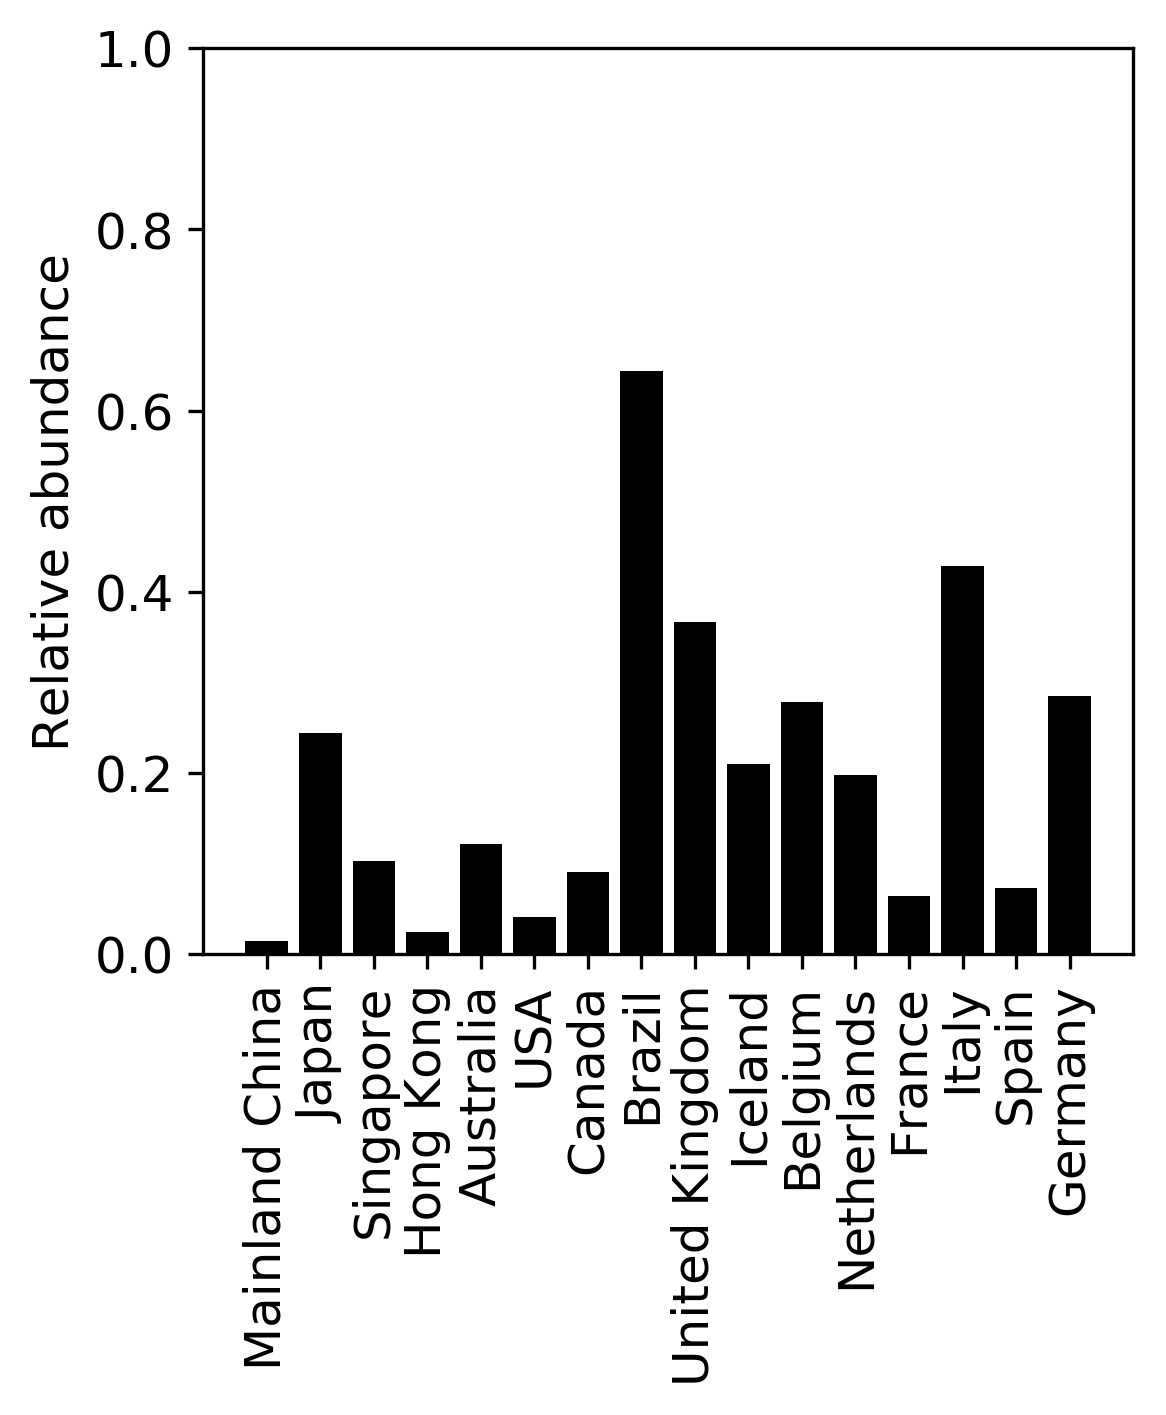

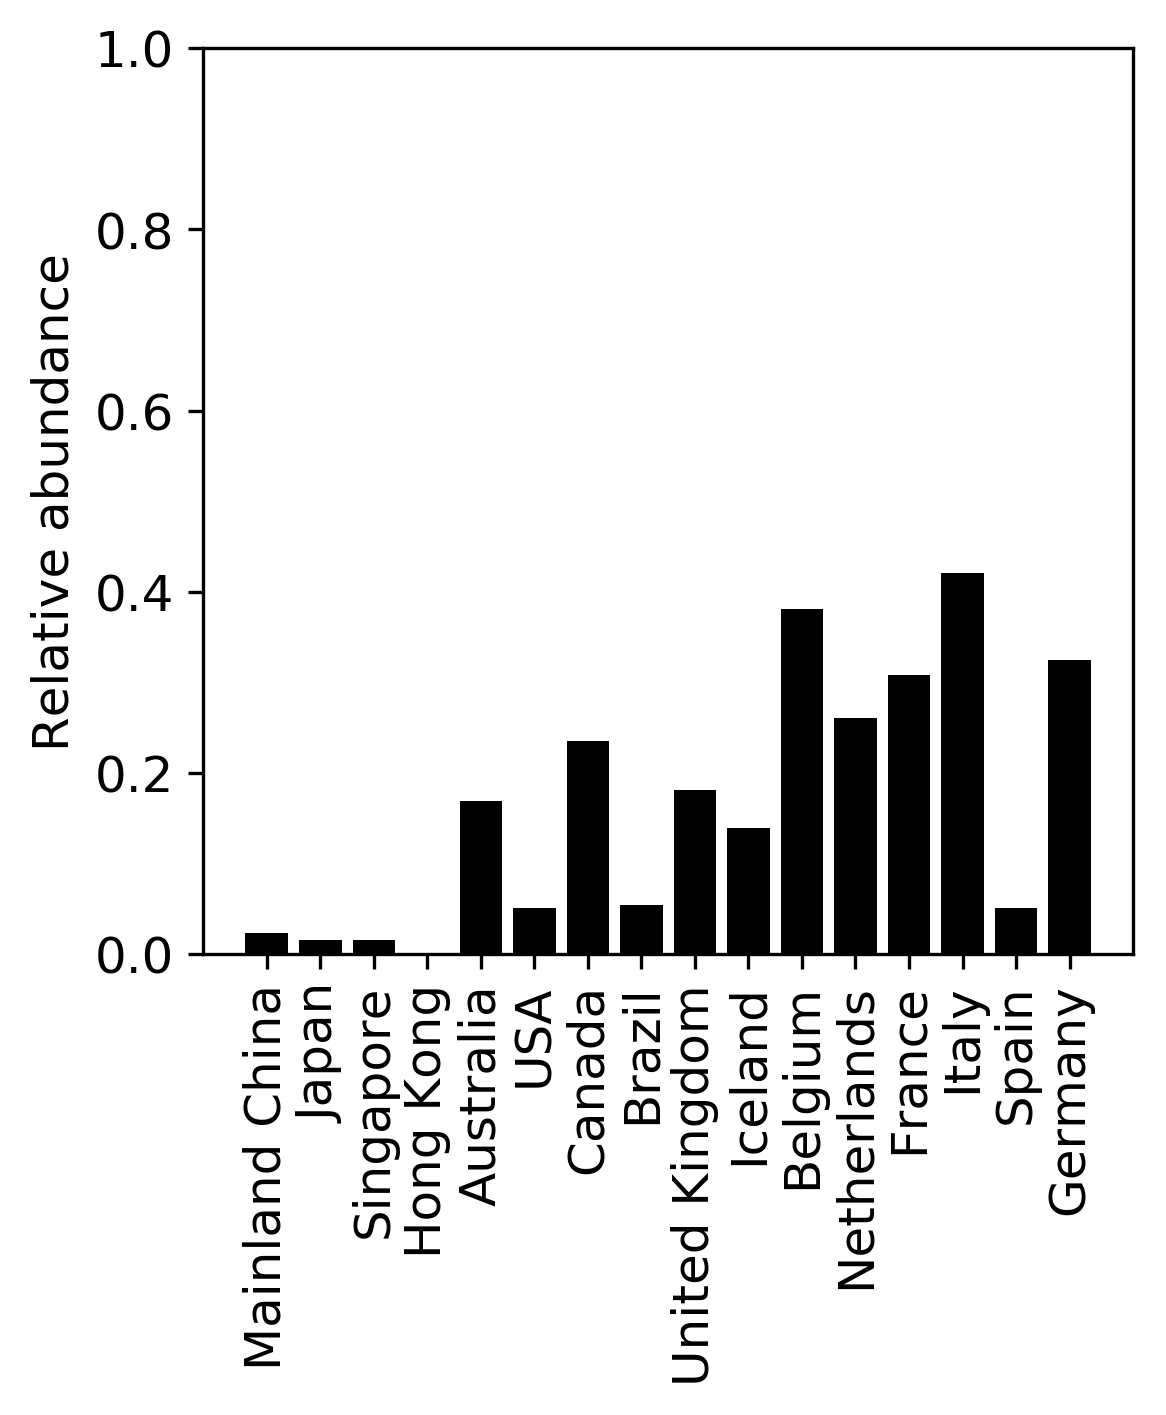

In [30]:
region_list = ['Mainland China', 'Japan', 'Singapore', 'Hong Kong',
                'Australia', 'USA', 'Canada', 'Brazil',
                'United Kingdom', 'Iceland', 'Belgium', 'Netherlands',
                'France', 'Italy', 'Spain', 'Germany', 
               ]
TYPICAL_ISM_list = list(ISM_df[ISM_df['country/region'] == 'Italy']['ISM'].value_counts()[:2].keys())
for TYPICAL_ISM in TYPICAL_ISM_list:
    ISM_cross_regions = regional_typical_ISM_bar(TYPICAL_ISM, region_list, region_raw_count)
    fig = plt.figure(figsize=(1200/DPI, 1200/DPI), dpi=DPI)   

    x = np.arange(len(region_list))
    plt.ylim([0, 1])
    plt.bar(x, ISM_cross_regions, color = 'black')
    plt.xticks(x, region_list, rotation = 90)
    plt.ylabel('Relative abundance')
    plt.savefig('{}/5_TYPICAL_ISM_{}_histogram_short.pdf'.format(output_folder, TYPICAL_ISM), bbox_inches='tight', dpi=DPI)
    plt.show()

In [31]:
IMS_FILTER_THRESHOLD = 0.025

start_date = datetime.date(2019, 12, 1)
end_date = datetime.date(int(2020), int(6), int(17))
delta = datetime.timedelta(days=1)
region_list = ['Mainland China', 'Japan', 'USA', 'France', 'Denmark', 'United Kingdom', 'Netherlands', 'Australia', 'Canada', 'Spain']
count_list = []
date_list = []
world_total_list = []
while start_date <= end_date:
    df_tmp = time_subset(ISM_df, '2019-11-01', str(start_date))
    if df_tmp.shape[0] == 0:
        start_date += delta
        continue
    world_total_list.append(df_tmp.shape[0])
    df_tmp_tmp = frequency_count(df_tmp)
    dict_freq = {}
    for region in region_list:
        regional_dict_freq = regional_timeseries_analysis(df_tmp_tmp, region)
        dict_freq_filtered = ISM_filter(regional_dict_freq, IMS_FILTER_THRESHOLD)
        ISM_set.update(dict_freq_filtered.keys())
        dict_freq[region] = regional_dict_freq
    count_list.append(dict_freq)
    date_list.append(start_date)
    start_date += delta

In [32]:
print('Need {} distinctive colors'.format(len(ISM_set)))
[long_COLOR_HEX, long_COLOR_DICT] = joblib.load('{}/ISM_color.joblib'.format('20200617_REVISION'))

Need 37 distinctive colors


In [33]:
COLOR_DICT = {}
for short in ISM_set:
    if short == 'OTHER':
        COLOR_DICT[short] = long_COLOR_DICT[short]
    else:
        long = short_to_long[short][0]
        COLOR_DICT[short] = long_COLOR_DICT[long]

In [34]:
def global_color_map(COLOR_DICT, ISM_list, out_dir='figures'):   
    # adapted from https://matplotlib.org/3.1.0/gallery/color/named_colors.html
    ncols = 2
    n = len(COLOR_DICT)
    nrows = n // ncols + int(n % ncols > 0)

    cell_width = 1200
    cell_height = 100
    swatch_width = 180
    margin = 24
    topmargin = 40

    width = cell_width * 3 + 2 * margin
    height = cell_height * nrows + margin + topmargin
    dpi = 300

    fig, ax = plt.subplots(figsize=(width / dpi, height / dpi), dpi=dpi)
    fig.subplots_adjust(margin/width, margin/height,
                        (width-margin)/width, (height-topmargin)/height)

    ax.set_xlim(0, cell_width * 4)
    ax.set_ylim(cell_height * (nrows-0.5), -cell_height/2.)
    ax.yaxis.set_visible(False)
    ax.xaxis.set_visible(False)
    ax.set_axis_off()
    # ax.set_title(title, fontsize=24, loc="left", pad=10)
    ISM_list.append('OTHER')
    for i, name in enumerate(ISM_list):
        row = i % nrows
        col = i // nrows
        y = row * cell_height

        swatch_start_x = cell_width * col
        swatch_end_x = cell_width * col + swatch_width
        text_pos_x = cell_width * col + swatch_width + 50

        ax.text(text_pos_x, y, name, fontsize=14,
                fontname='monospace',
                horizontalalignment='left',
                verticalalignment='center')

        ax.hlines(y, swatch_start_x, swatch_end_x,
                  color=COLOR_DICT[name], linewidth=18)
    plt.savefig('{}/add_color_map_short.pdf'.format(out_dir), bbox_inches='tight', dpi=dpi)
    plt.show()

Global color map:


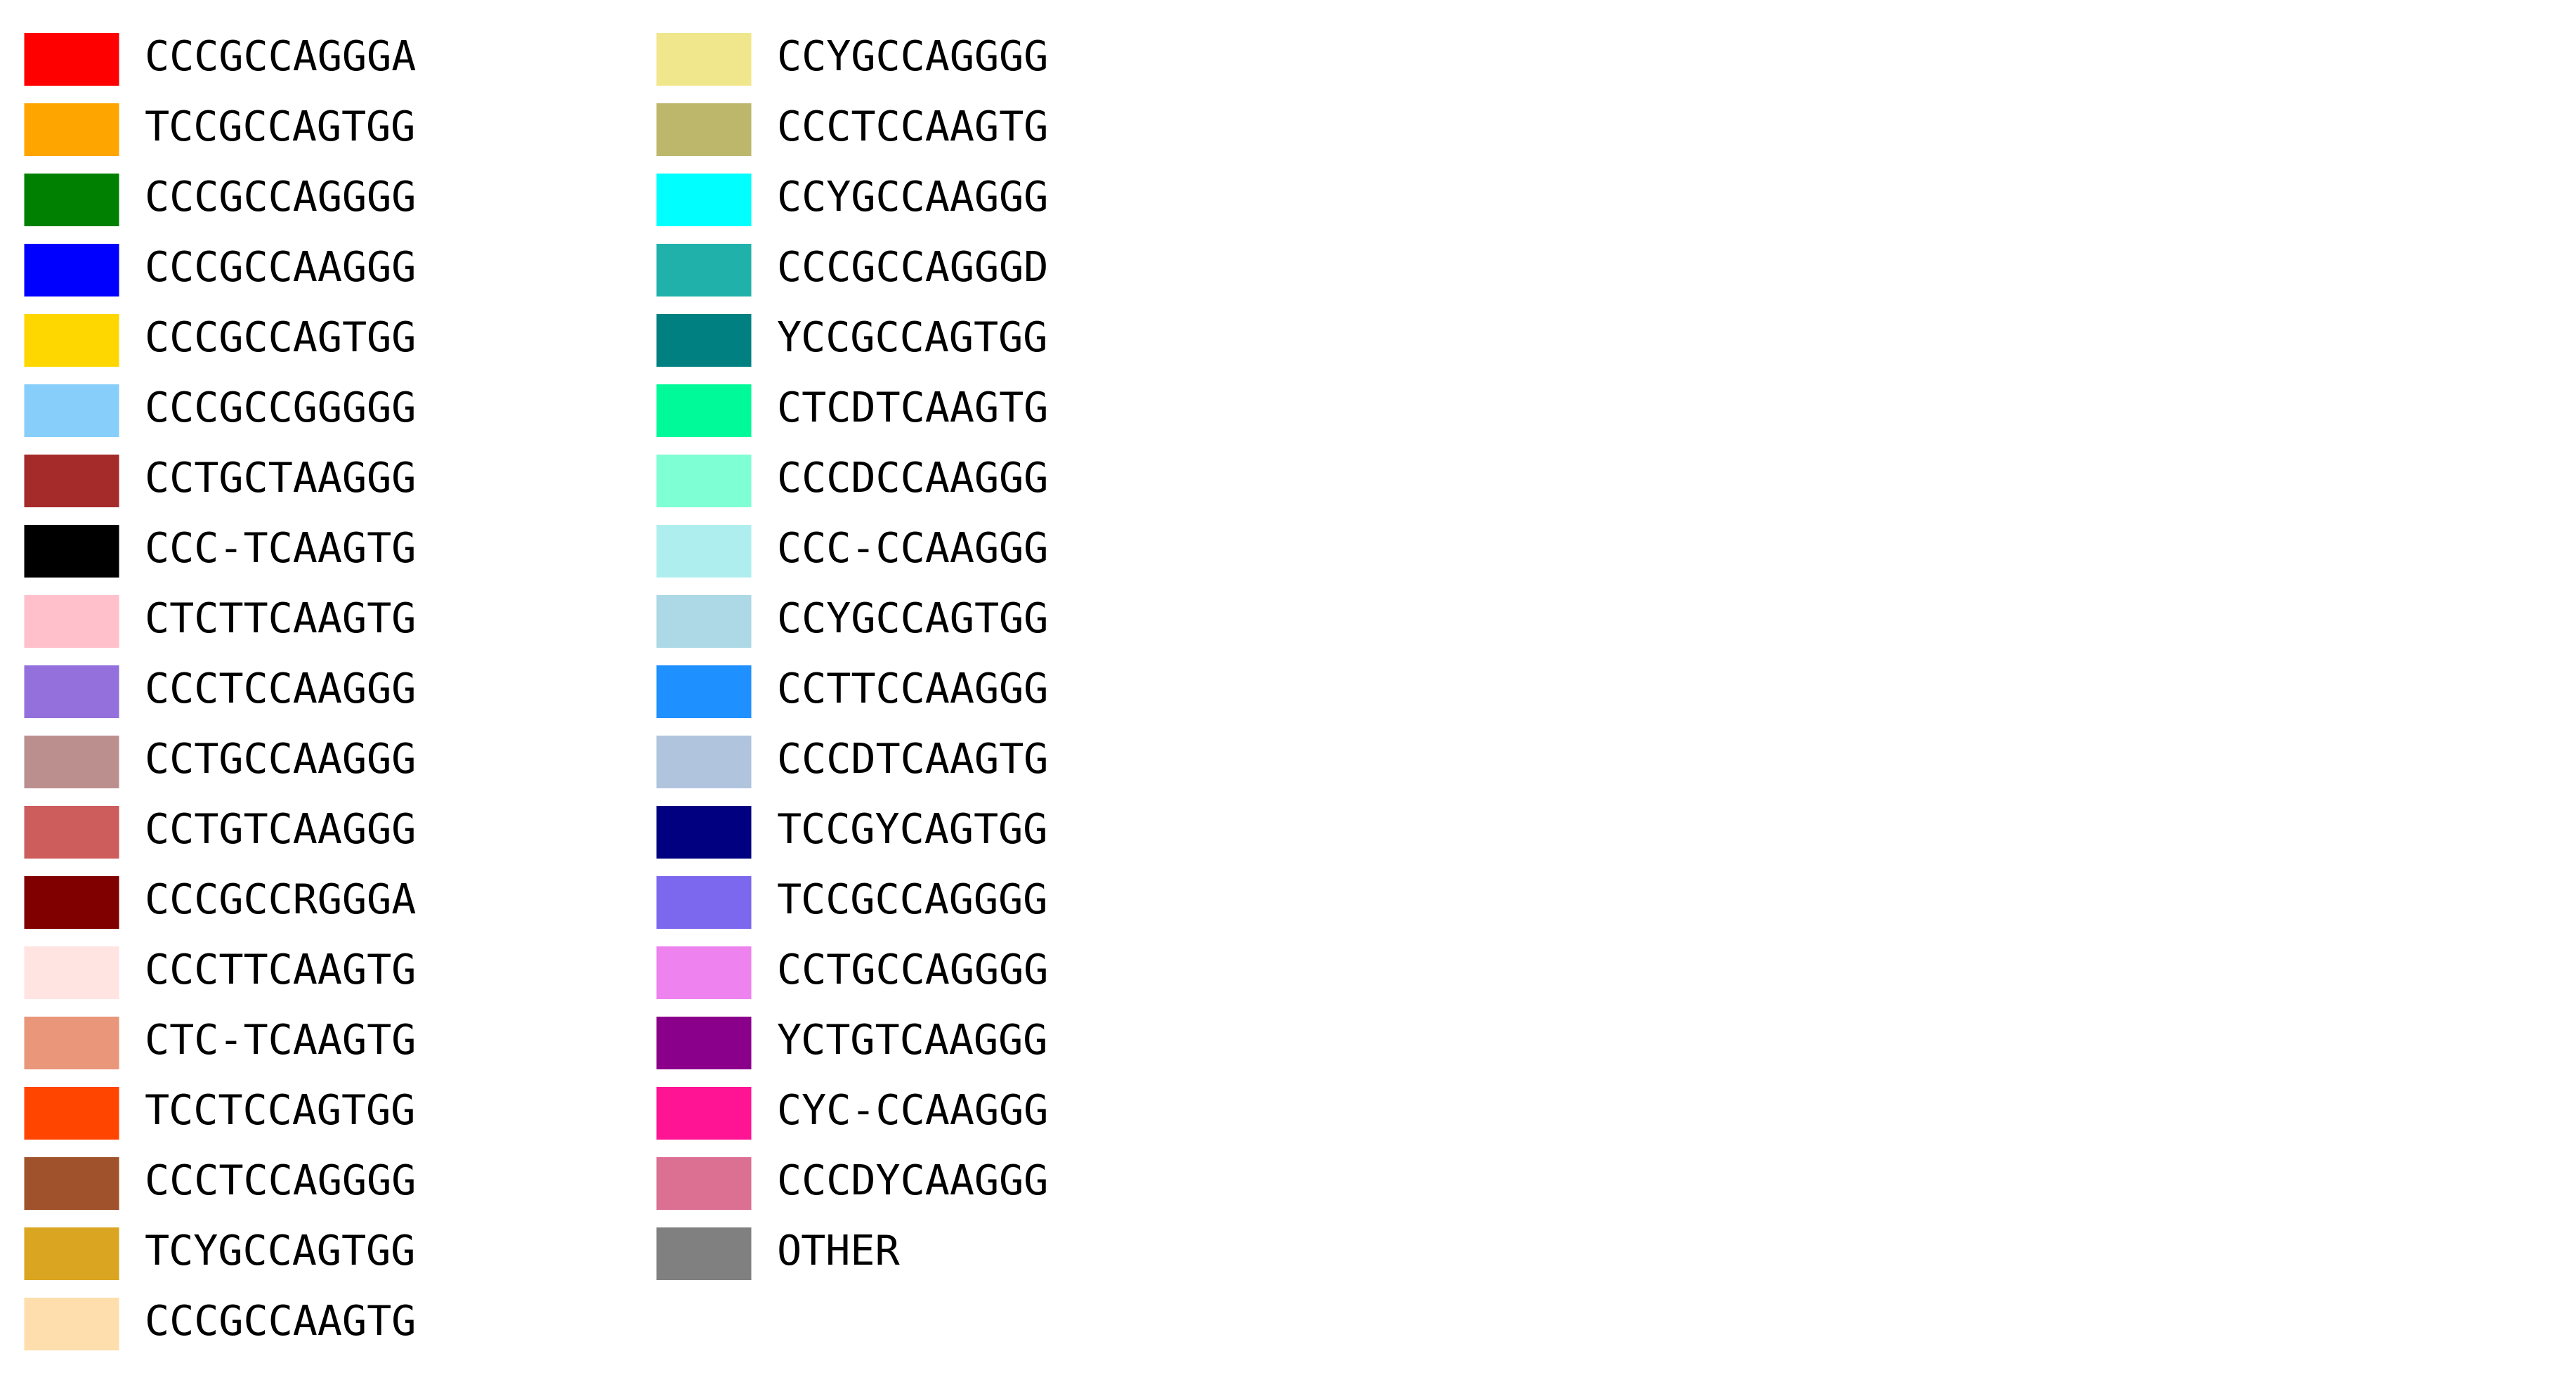

In [35]:
ISM_list = []
for ISM in ISM_set:
    if ISM == 'OTHER':
        continue
    ISM_list.append((ISM, ISM_index[ISM]))
ISM_list = sorted(ISM_list, key = lambda x: x[1])
ISM_list = [item[0] for item in ISM_list]
print('Global color map:')
global_color_map(COLOR_DICT, ISM_list, out_dir=output_folder)

In [36]:
COLOR_HEX = {}
for ISM in COLOR_DICT:
#     print(ISM, matplotlib.colors.cnames[COLOR_DICT[ISM]])
    COLOR_HEX[ISM] = matplotlib.colors.cnames[COLOR_DICT[ISM]]
joblib.dump([COLOR_HEX, COLOR_DICT], '{}/ISM_color_short.joblib'.format(output_folder))

['20200617_REVISION_SHORT/ISM_color_short.joblib']

In [37]:
# https://matplotlib.org/3.1.1/gallery/pie_and_polar_charts/pie_and_donut_labels.html#sphx-glr-gallery-pie-and-polar-charts-pie-and-donut-labels-py
def func(pct, allvals):
    absolute = int(round(pct/100.*np.sum(allvals)))
    return "{:d}".format(absolute)
def plot_pie_chart(sizes, labels, colors, ax):
    wedges, texts, autotexts = ax.pie(sizes, autopct=lambda pct: func(pct, sizes), colors = colors, textprops=dict(color="w"))
    time_labels = ['-' if label == 'OTHER' else label.split(' ')[1] for label in labels]
    ax.legend(wedges, time_labels,
#           title="Oligotypes",
          loc="lower left",
          bbox_to_anchor=(0.8, 0, 0.5, 1))
    ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    return wedges, labels

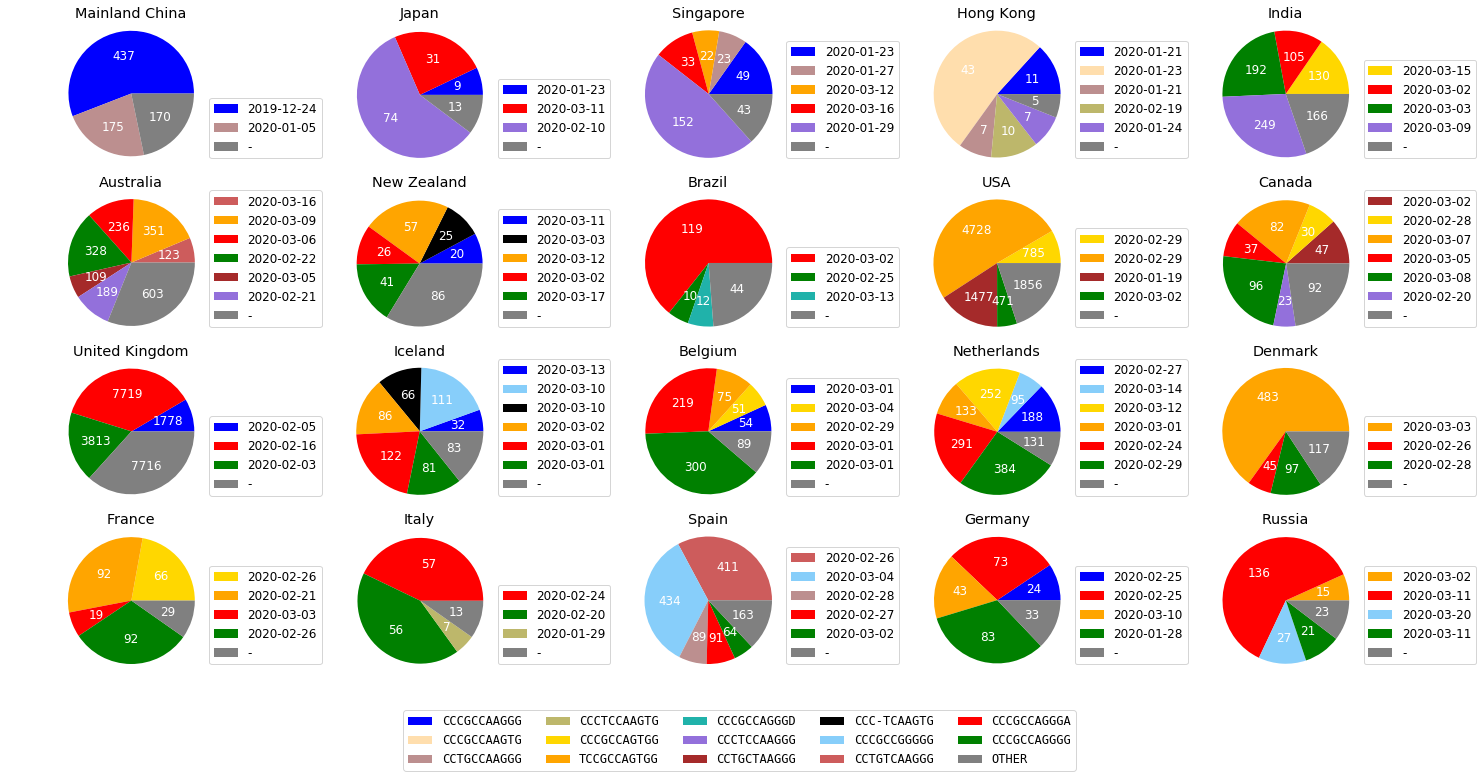

In [38]:
# fig = plt.figure(figsize=(2100/DPI, 2100/DPI), dpi=DPI)   
fig = plt.figure(figsize=(25, 15))   
region_list = ['Mainland China', 'Japan', 'Singapore', 'Hong Kong', 'India',
               'Australia', 'New Zealand', 'Brazil', 'USA', 'Canada', 
               'United Kingdom', 'Iceland', 'Belgium', 'Netherlands', 'Denmark',
               'France', 'Italy', 'Spain', 'Germany', 'Russia',
               ]

# region_list = ['Mainland China', 'Japan', 'Singapore',
#                 'Australia', 'USA', 'Canada', 
#                 'United Kingdom', 'Netherlands', 'France', 
#                'Italy', 'Spain', 'Germany', 
#                ]
wedges_list = []
for idx, region in enumerate(region_list):
    dict_freq = region_pie_chart[region]
    total = sum([dict_freq[ISM][1] for ISM in dict_freq])
    labels = []
    sizes = []
    colors = []

    for ISM in dict_freq:
        if ISM == 'OTHER':
            continue
        labels.append('{}: {}'.format(ISM, np.datetime_as_string(dict_freq[ISM][0], unit='D')))
        colors.append(COLOR_DICT[ISM])
        sizes.append(dict_freq[ISM][1])
    if 'OTHER' in dict_freq:
        labels.append('OTHER')
        colors.append(COLOR_DICT['OTHER'])
        sizes.append(dict_freq['OTHER'][1])
    
    ax=plt.subplot(5, 5, idx+1)
    wedges, labels = plot_pie_chart(sizes, labels, colors, ax)
    ax.set_title(region)
    wedges_list.append((wedges, labels))

labels_handles = {}
handles_OTHER = None
for wedges, labels in wedges_list:
    for idx, label in enumerate(labels):
        label = label.split(':')[0]
        if label == 'OTHER':
            handles_OTHER = [wedges[idx], label]
            continue
        if label not in labels_handles:
            labels_handles[label] = wedges[idx]
if handles_OTHER:
    handles_list = list(labels_handles.values()) + [handles_OTHER[0]]
    labels_list = list(labels_handles.keys()) + [handles_OTHER[1]]
    fig.legend(
      handles_list,
      labels_list,
#       loc="lower center",
      bbox_to_anchor=(0.72, 0.25),
      bbox_transform=plt.gcf().transFigure,
      ncol=5,
      prop={'family': monospace_font['fontname']}
    )
else:
    fig.legend(
      labels_handles.values(),
      labels_handles.keys(),
      loc="lower center",
      bbox_to_anchor=(0.72, 0.25),
#       bbox_transform=plt.gcf().transFigure,
      ncol=5,
      prop={'family': monospace_font['fontname']}
    )
plt.savefig('{}/6_regional_ISM_short.pdf'.format(output_folder), bbox_inches='tight', dpi=DPI, transparent=True)
plt.show()

In [39]:
IMS_FILTER_THRESHOLD = 0.05

state_pie_chart = {}
state_pie_raw = {}
for idx, state in enumerate(state_list):
    dict_freq = statewise_analysis(intra_usa_ISM_count_date, state)
    dict_freq_filtered = ISM_filter(dict_freq, IMS_FILTER_THRESHOLD)
    state_pie_chart[state] = dict_freq_filtered
    state_pie_raw[state] = dict_freq
    ISM_set.update(dict_freq_filtered.keys())

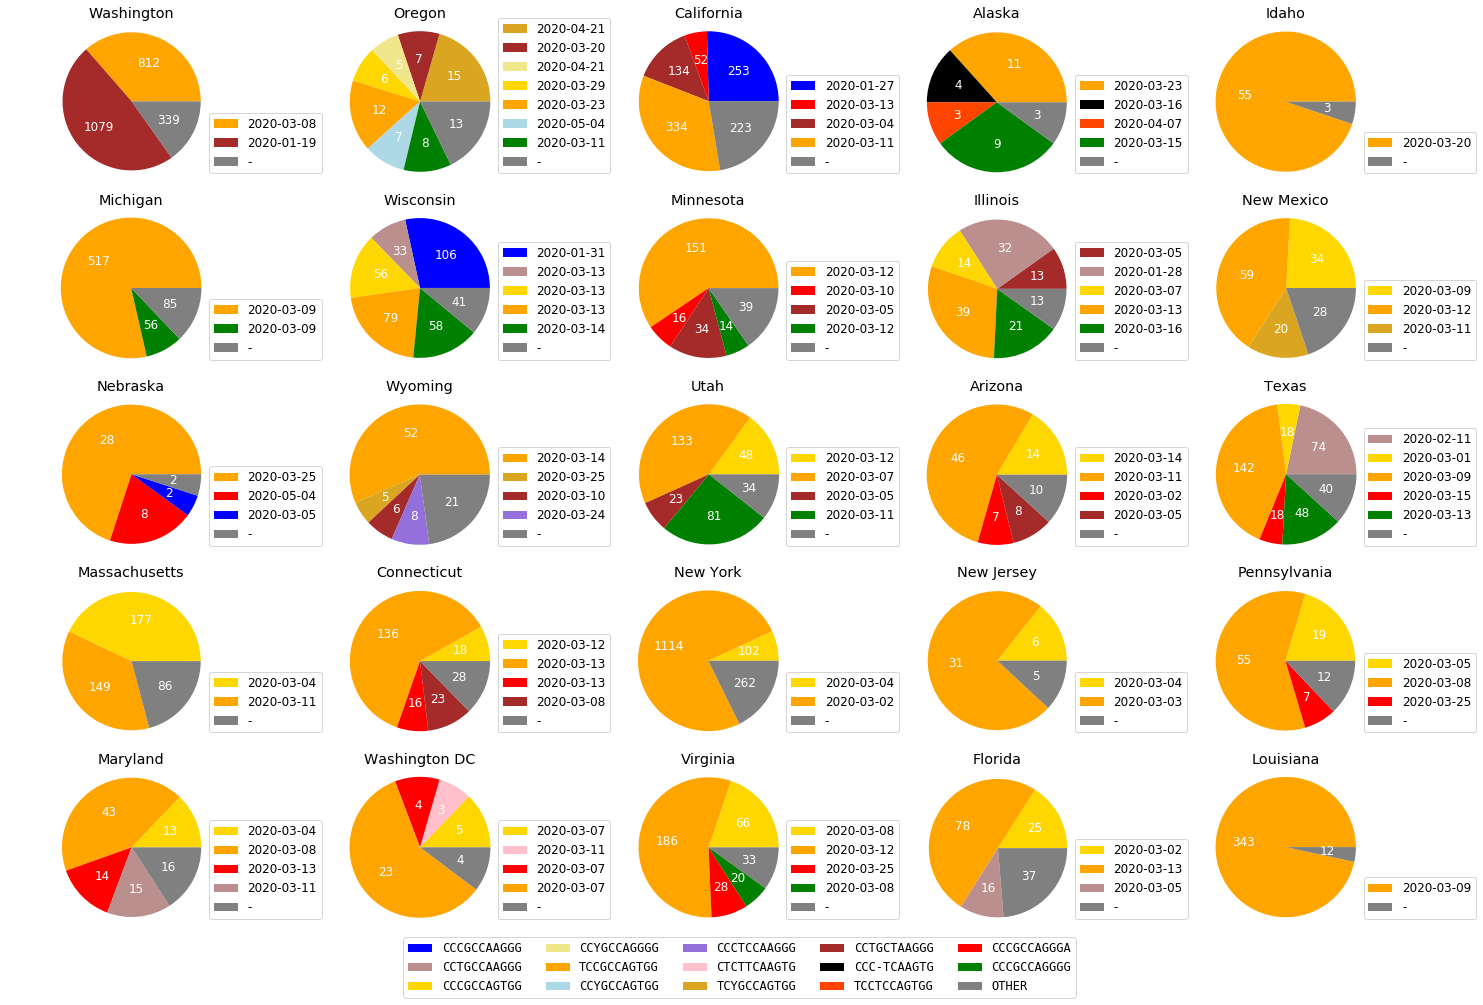

In [40]:
# fig = plt.figure(figsize=(2100/DPI, 2100/DPI), dpi=DPI)   
fig = plt.figure(figsize=(25, 20))   

subplot_y = int(np.sqrt(len(state_list)))
subplot_x = int(np.sqrt(len(state_list))) + 1

if subplot_x * subplot_y < len(state_list):
    subplot_y = subplot_x
    
wedges_list = []
for idx, state in enumerate(state_list):
    dict_freq = state_pie_chart[state]
    total = sum([dict_freq[ISM][1] for ISM in dict_freq])
    labels = []
    sizes = []
    colors = []

    for ISM in dict_freq:
        if ISM == 'OTHER':
            continue
        labels.append('{}: {}'.format(ISM, np.datetime_as_string(dict_freq[ISM][0], unit='D')))
        colors.append(COLOR_DICT[ISM])
        sizes.append(dict_freq[ISM][1])
    if 'OTHER' in dict_freq:
        labels.append('OTHER')
        colors.append(COLOR_DICT['OTHER'])
        sizes.append(dict_freq['OTHER'][1])
    
    ax=plt.subplot(subplot_x, subplot_y, idx+1)
    wedges, labels = plot_pie_chart(sizes, labels, colors, ax)
    ax.set_title(state)
    wedges_list.append((wedges, labels))

labels_handles = {}
handles_OTHER = None
for wedges, labels in wedges_list:
    for idx, label in enumerate(labels):
        label = label.split(':')[0]
        if label == 'OTHER':
            handles_OTHER = [wedges[idx], label]
            continue
        if label not in labels_handles:
            labels_handles[label] = wedges[idx]
if handles_OTHER:
    handles_list = list(labels_handles.values()) + [handles_OTHER[0]]
    labels_list = list(labels_handles.keys()) + [handles_OTHER[1]]
    fig.legend(
      handles_list,
      labels_list,
#       loc="lower center",
      bbox_to_anchor=(0.72, 0.25),
      bbox_transform=plt.gcf().transFigure,
      ncol=5,
      prop={'family': monospace_font['fontname']}
    )
else:
    fig.legend(
      labels_handles.values(),
      labels_handles.keys(),
#       loc="lower center",
      bbox_to_anchor=(0.72, 0.25),
      bbox_transform=plt.gcf().transFigure,
      ncol=5,
      prop={'family': monospace_font['fontname']}
    )
plt.savefig('{}/7_intra-US_ISM_short.pdf'.format(output_folder), bbox_inches='tight', dpi=DPI, transparent=True)
plt.show()

In [41]:
font = {# 'family' : 'serif', # Times (source: https://matplotlib.org/tutorials/introductory/customizing.html)
        'family': 'sans-serif', # Helvetica
#         'family': 'monospace',
#         'weight' : 'bold',
        'size'   : 25}
matplotlib.rc('font', **font) 
IMS_FILTER_THRESHOLD = 0.025

def regional_growth_plot(region, ISM_df, REFERENCE_date, count_list, date_list):
    
    xlim_len = (ISM_df[ISM_df['country/region'] == region]['date'].max().date() - REFERENCE_date).days
    
    fig = plt.figure(figsize = (30, 15))
#     fig = plt.figure(figsize=(2100/DPI, 1200/DPI), dpi=DPI)   
    n = 4
    ax=plt.subplot(1, 1, 1)
    
    regional_total = []
    ISM_regional_set = set([])
    for i in range(len(count_list)):
        regional_dict_freq = count_list[i][region]
        regional_total.append(sum([regional_dict_freq[ISM][1] for ISM in regional_dict_freq]))
        dict_freq_filtered = ISM_filter(regional_dict_freq, IMS_FILTER_THRESHOLD)
        ISM_regional_set.update(dict_freq_filtered.keys())
    ISM_regional_list = []
    for ISM in ISM_regional_set:
        if ISM != 'OTHER':
            ISM_regional_list.append(ISM)
    NONOTHER = len(ISM_regional_list)
    if 'OTHER' in ISM_regional_set:
        ISM_regional_list.append('OTHER')
#     y = np.zeros(len(count_list))
    for ISM in ISM_regional_list:
        ISM_regional_growth = []
            
        for i in range(len(count_list)):
            regional_dict_freq = count_list[i][region]
#      ======== old method 1 ========
#             dict_freq_filtered = ISM_filter(regional_dict_freq, IMS_FILTER_THRESHOLD)
#             if ISM in dict_freq_filtered and dict_freq_filtered[ISM][1]!= 0:
#                 ISM_regional_growth.append(dict_freq_filtered[ISM][1]/regional_total[i])
#             else:
#                 ISM_regional_growth.append(0)
#      ======== new method 2 ========
            if ISM in regional_dict_freq and regional_dict_freq[ISM][1]!= 0:
                ISM_regional_growth.append(regional_dict_freq[ISM][1]/regional_total[i])
            else:
                if ISM == 'OTHER':
                    other_count = sum([regional_dict_freq[ISM][1] for ISM in regional_dict_freq if ISM not in ISM_regional_set])
                    if regional_total[i] != 0:
                        ISM_regional_growth.append(other_count/regional_total[i])
                    else:
                        ISM_regional_growth.append(0)
                else:
                    ISM_regional_growth.append(0)
#         y += np.array(ISM_regional_growth)
        ax.plot(ISM_regional_growth, color = COLOR_DICT[ISM], label = ISM, linewidth = 4, marker = 'o', markersize = 4)
#     print(y)
    ####
#     IDX = -1
#     total = sum([count_list[IDX][region][item][1] for item in count_list[IDX][region]])
#     res = []
#     for item in count_list[IDX][region]:
#         if item not in ISM_regional_set:
#             res.append((item, count_list[IDX][region][item][1], count_list[IDX][region][item][1]/total))
#     if region == 'Canada':
#         print(res)
#     if len(res) != 0:
#         print('{}, {}, {}, {}'.format(region, *sorted(res, key=lambda x: x[1], reverse = True)[0]))
    ####
        
    major_ticks = np.arange(0, len(date_list), 5)
    minor_ticks = np.arange(0, len(date_list))
    major_label = []
    
    for i in major_ticks.tolist():
        major_label.append(str(date_list[i]))
#     print(major_label)
    ax.set_xticks(minor_ticks, minor=True)
    ax.set_xticks(major_ticks)
    ax.set_xticklabels(major_label)
    plt.setp(ax.get_xticklabels(), rotation=90)
#     [l.set_visible(False) for (i,l) in enumerate(ax.axes.xaxis.get_ticklabels()) if i % n != 0]
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    plt.legend(#title="Oligotypes",
              loc="lower left",
              bbox_to_anchor=(1, 0, 0.5, 1),
              prop={'family': monospace_font['fontname']})
    plt.xlim([-1, xlim_len])
    plt.ylabel('Relative abundance')
    ax.grid(which='minor', alpha=0.3, linestyle='--')
    ax.grid(which='major', alpha=0.8)
    plt.savefig('{}/8_ISM_growth_{}_short.pdf'.format(output_folder, region), bbox_inches='tight')
    plt.show()  

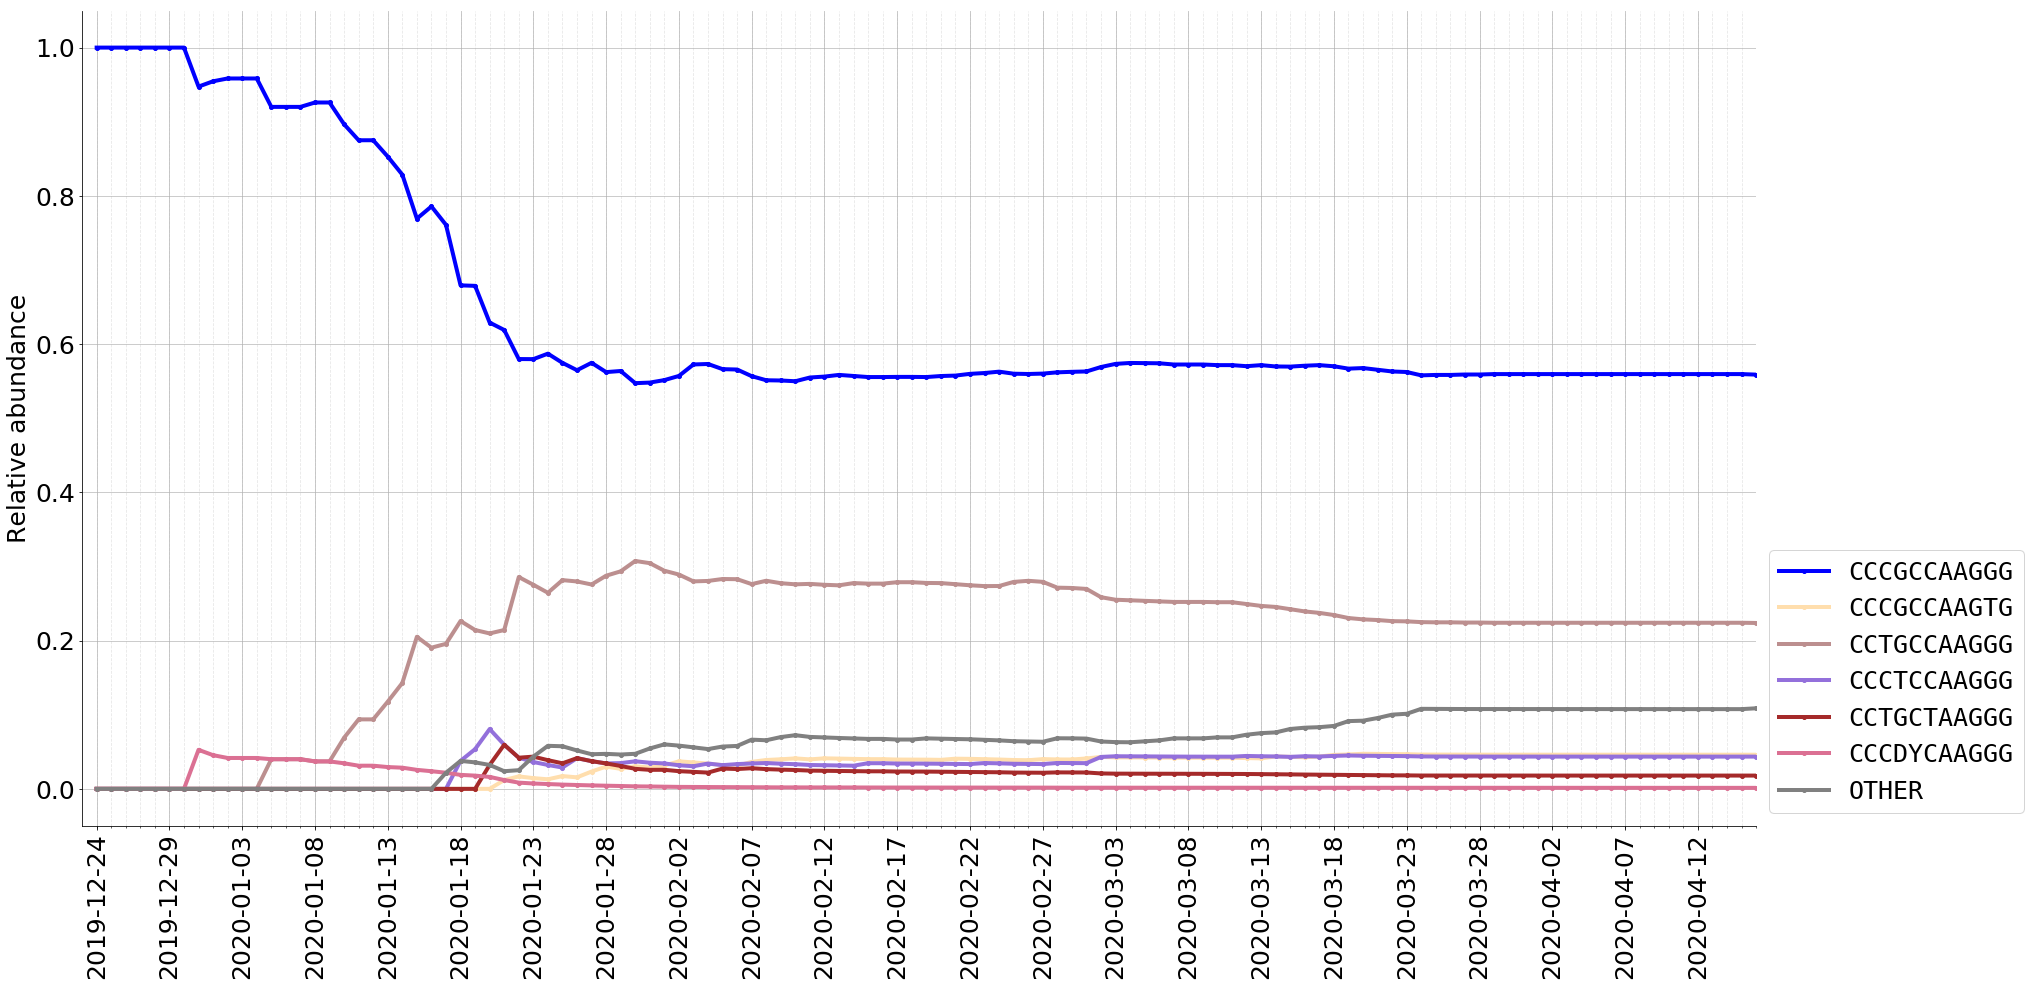

In [42]:
regional_growth_plot('Mainland China', ISM_df, REFERENCE_date, count_list, date_list)

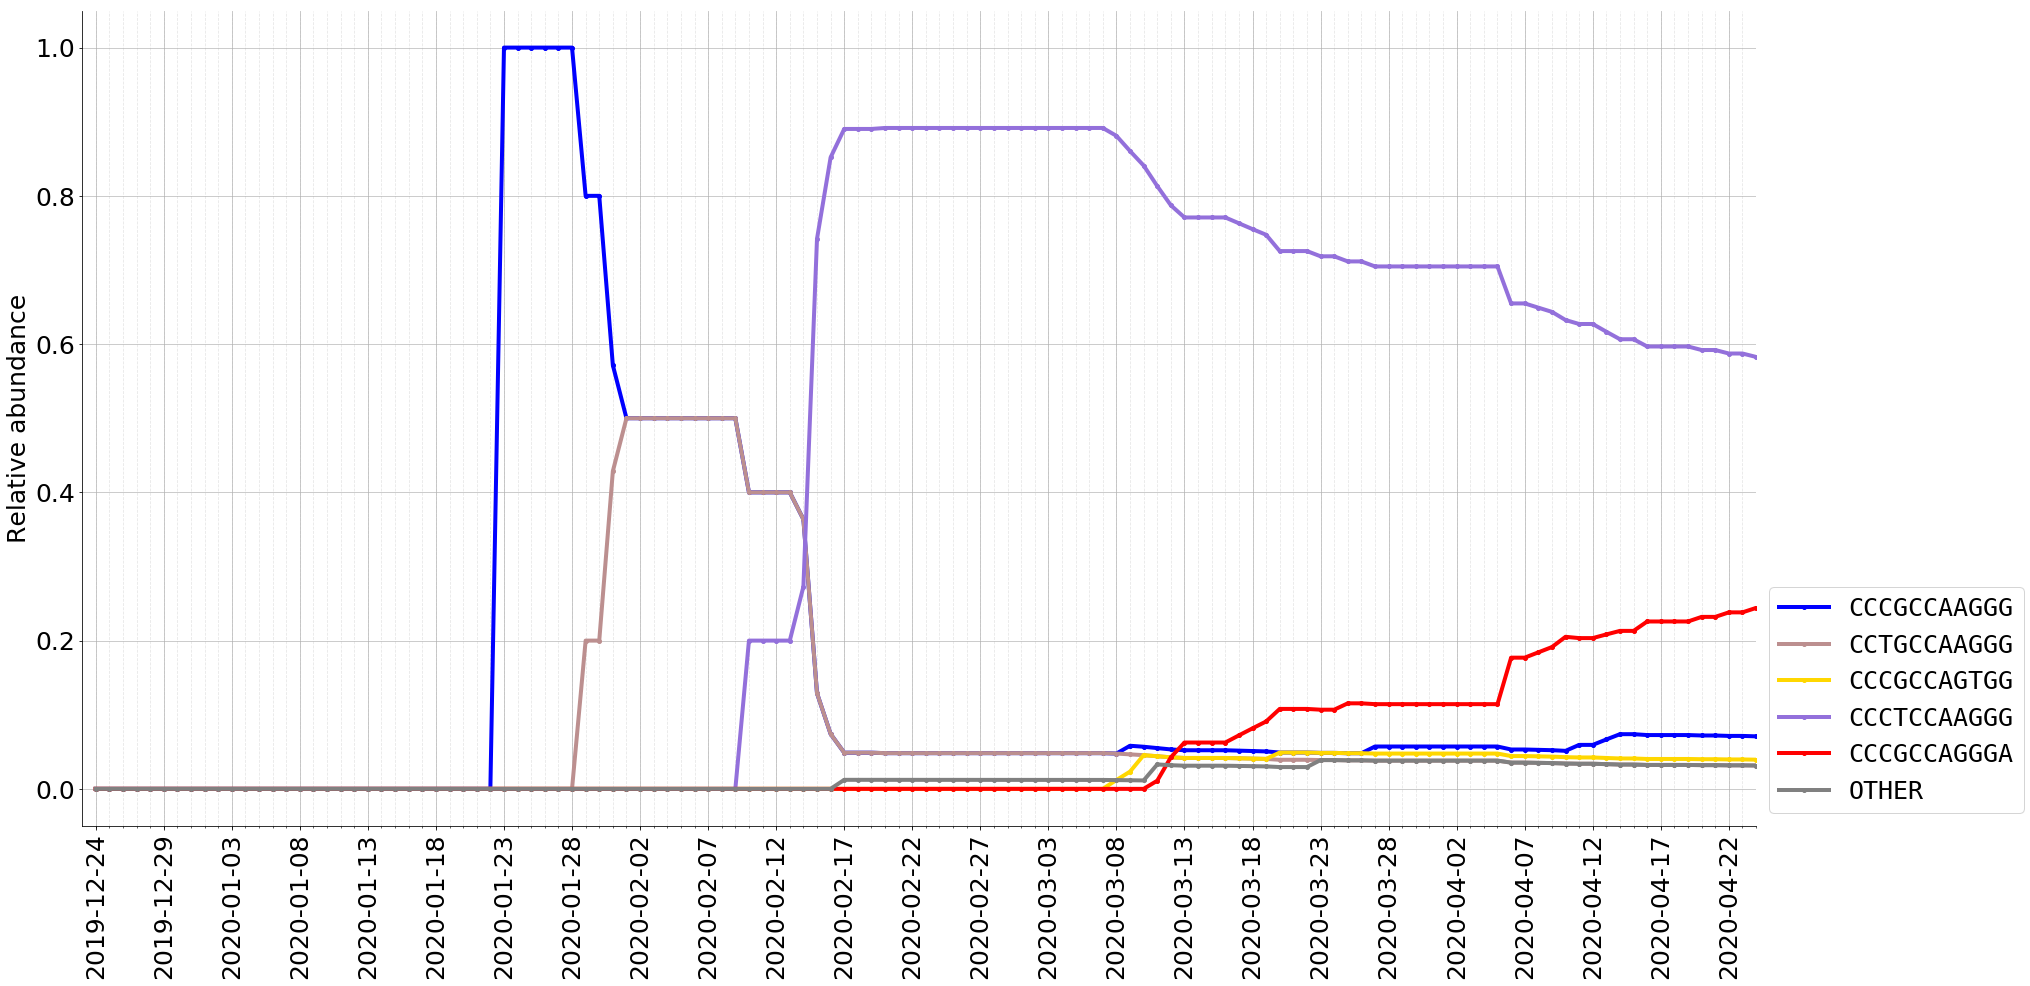

In [43]:
regional_growth_plot('Japan', ISM_df, REFERENCE_date, count_list, date_list)

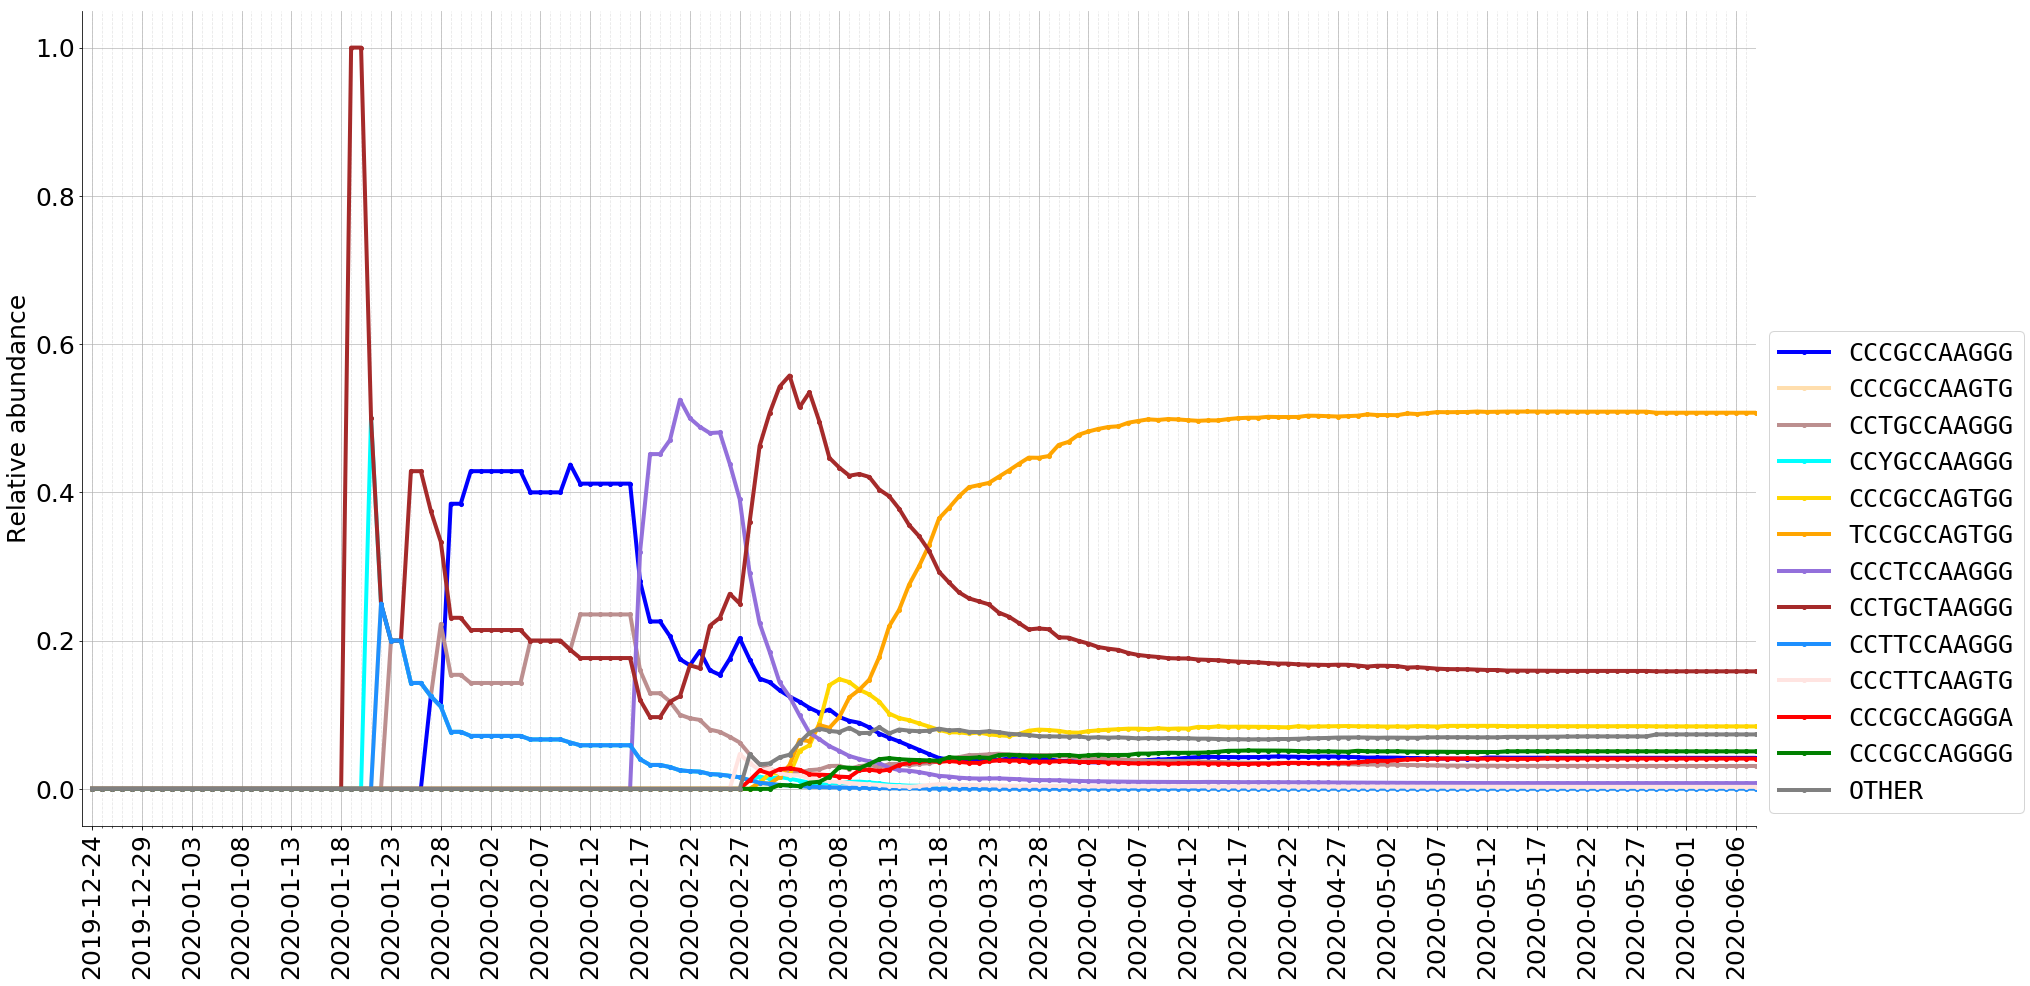

In [44]:
regional_growth_plot('USA', ISM_df, REFERENCE_date, count_list, date_list)

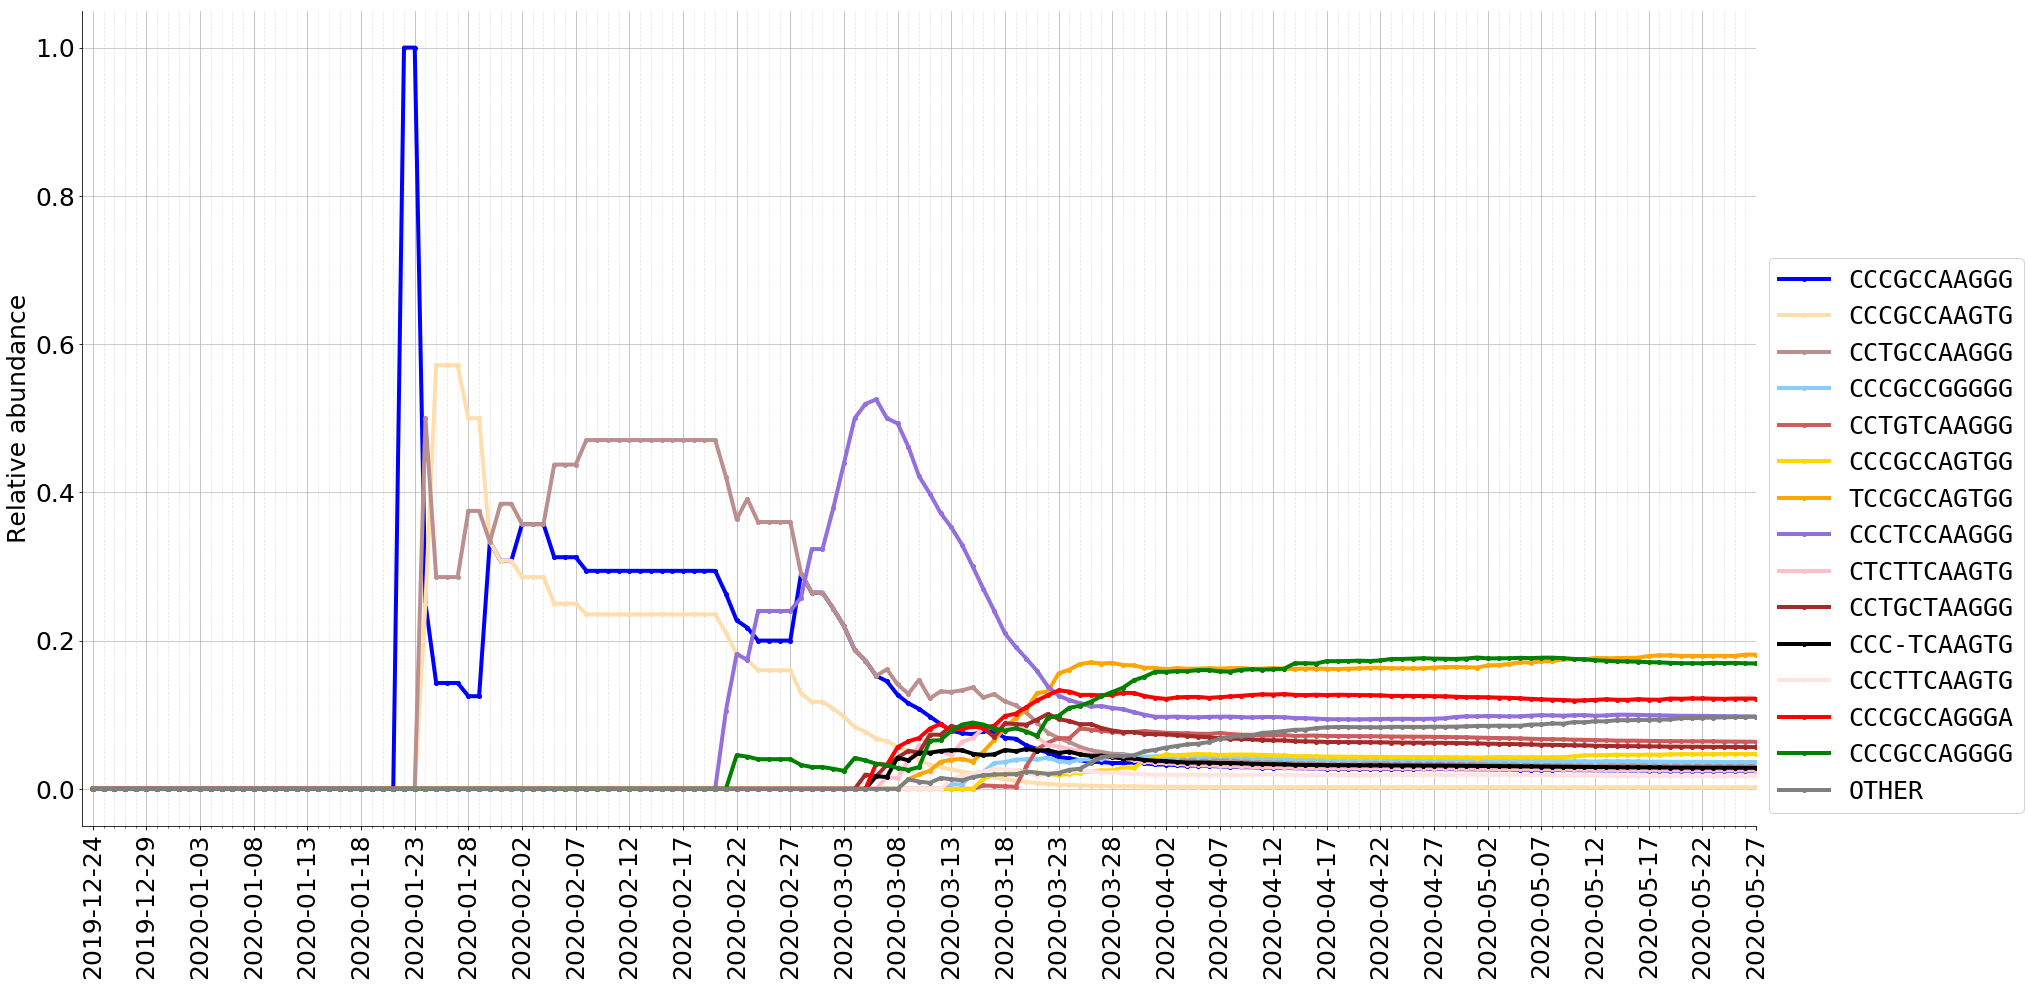

In [45]:
regional_growth_plot('Australia', ISM_df, REFERENCE_date, count_list, date_list)

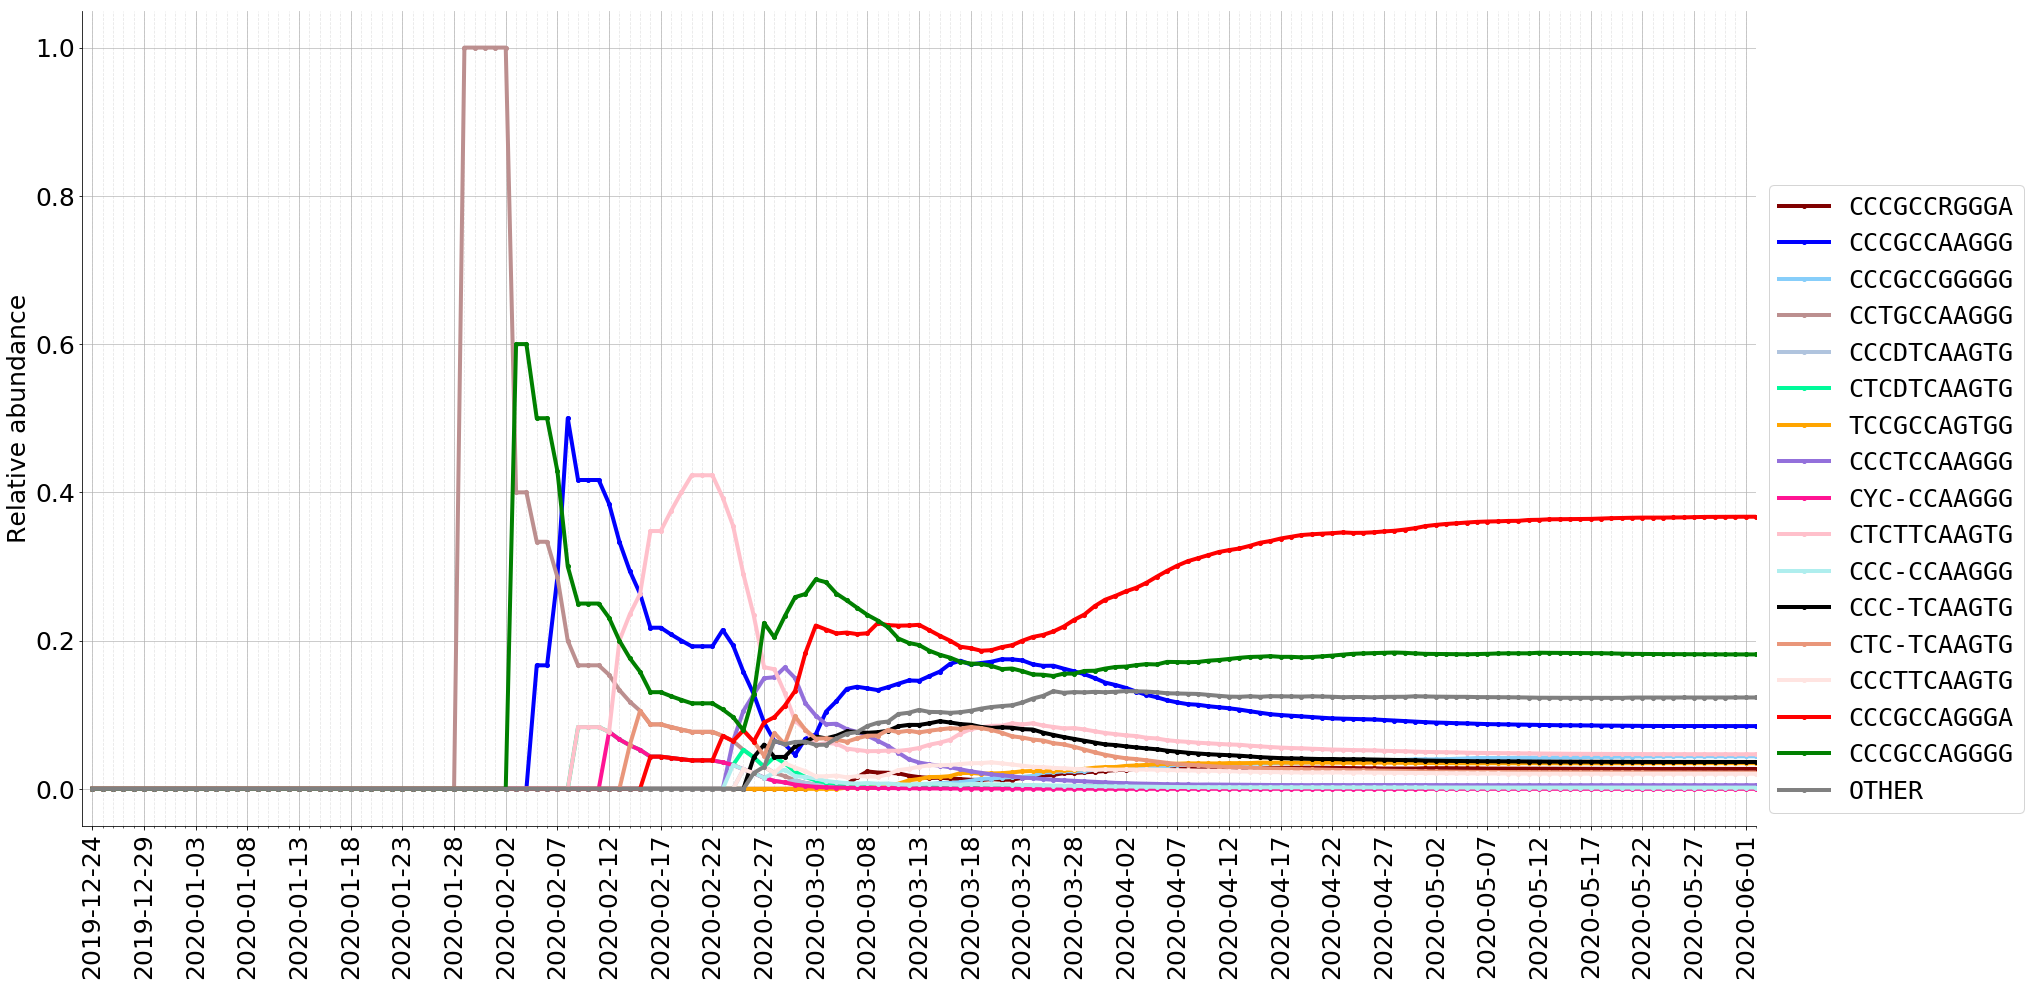

In [46]:
regional_growth_plot('United Kingdom', ISM_df, REFERENCE_date, count_list, date_list)

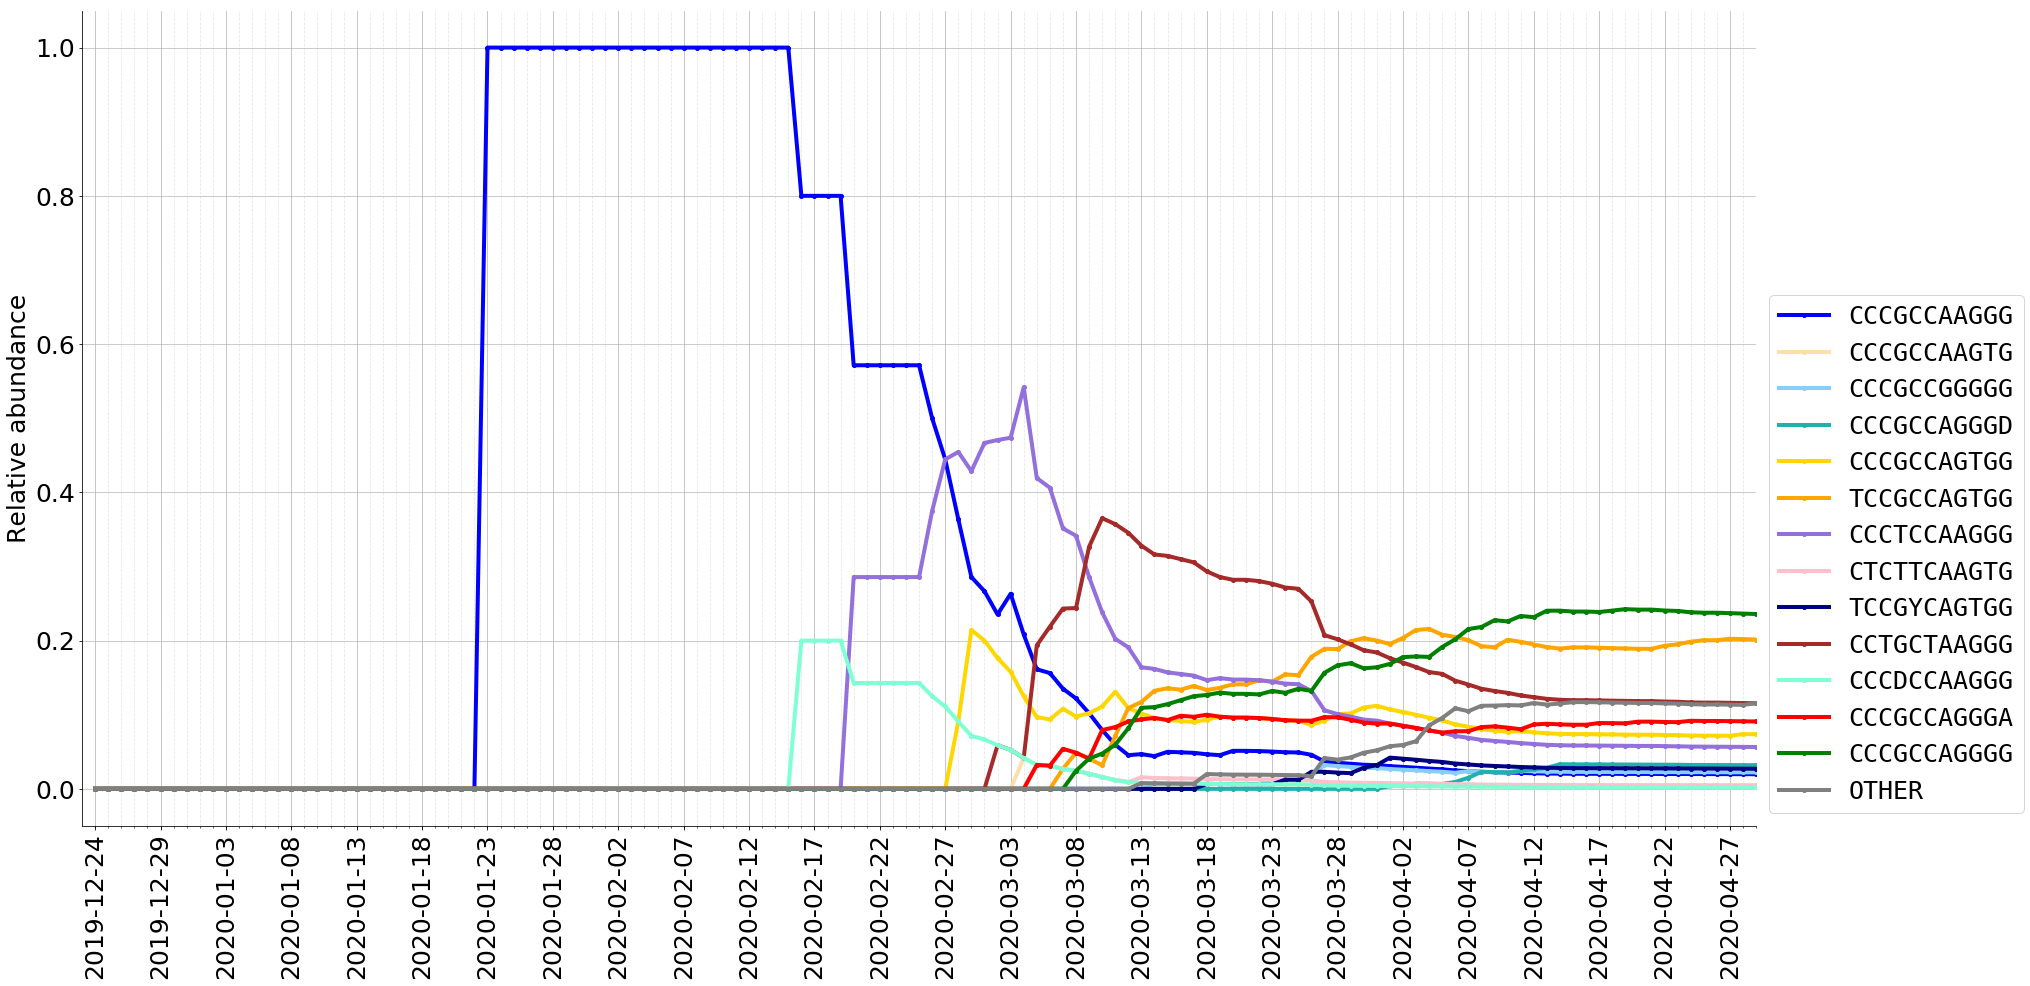

In [47]:
regional_growth_plot('Canada', ISM_df, REFERENCE_date, count_list, date_list)

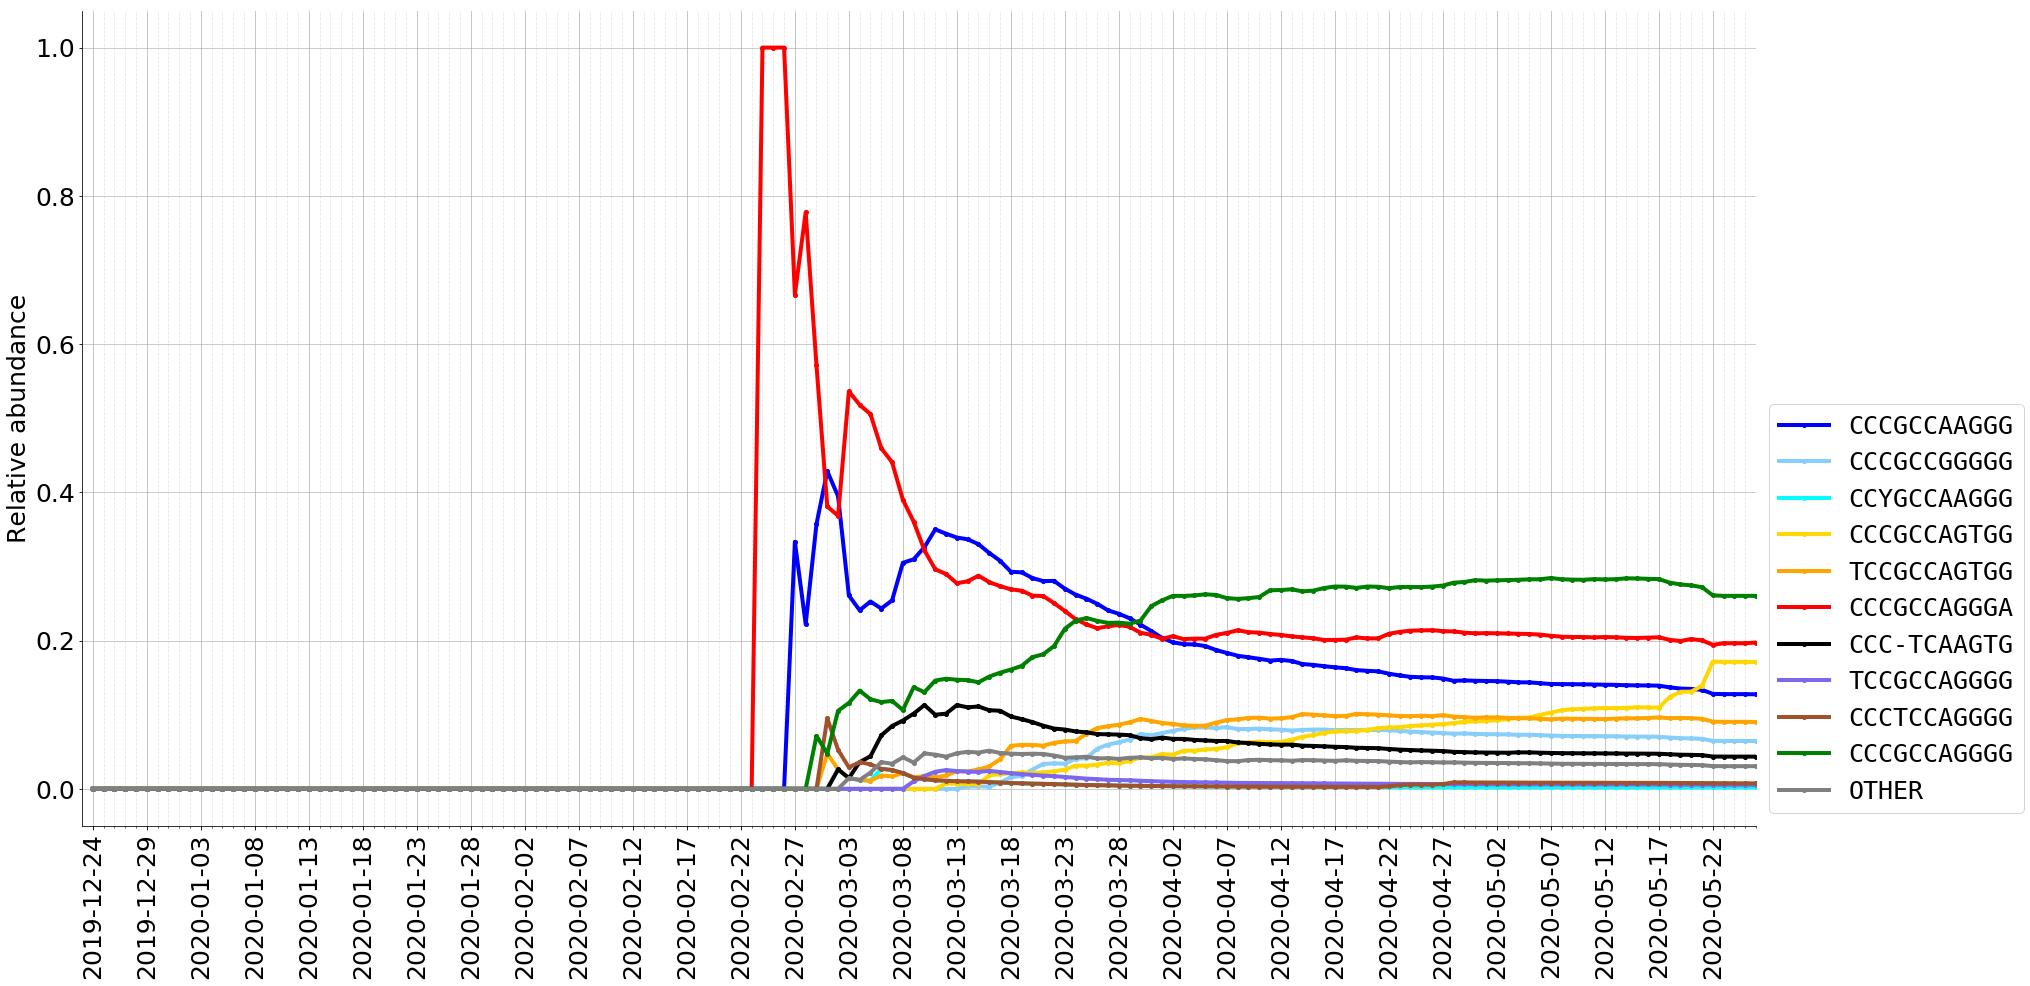

In [48]:
regional_growth_plot('Netherlands', ISM_df, REFERENCE_date, count_list, date_list)

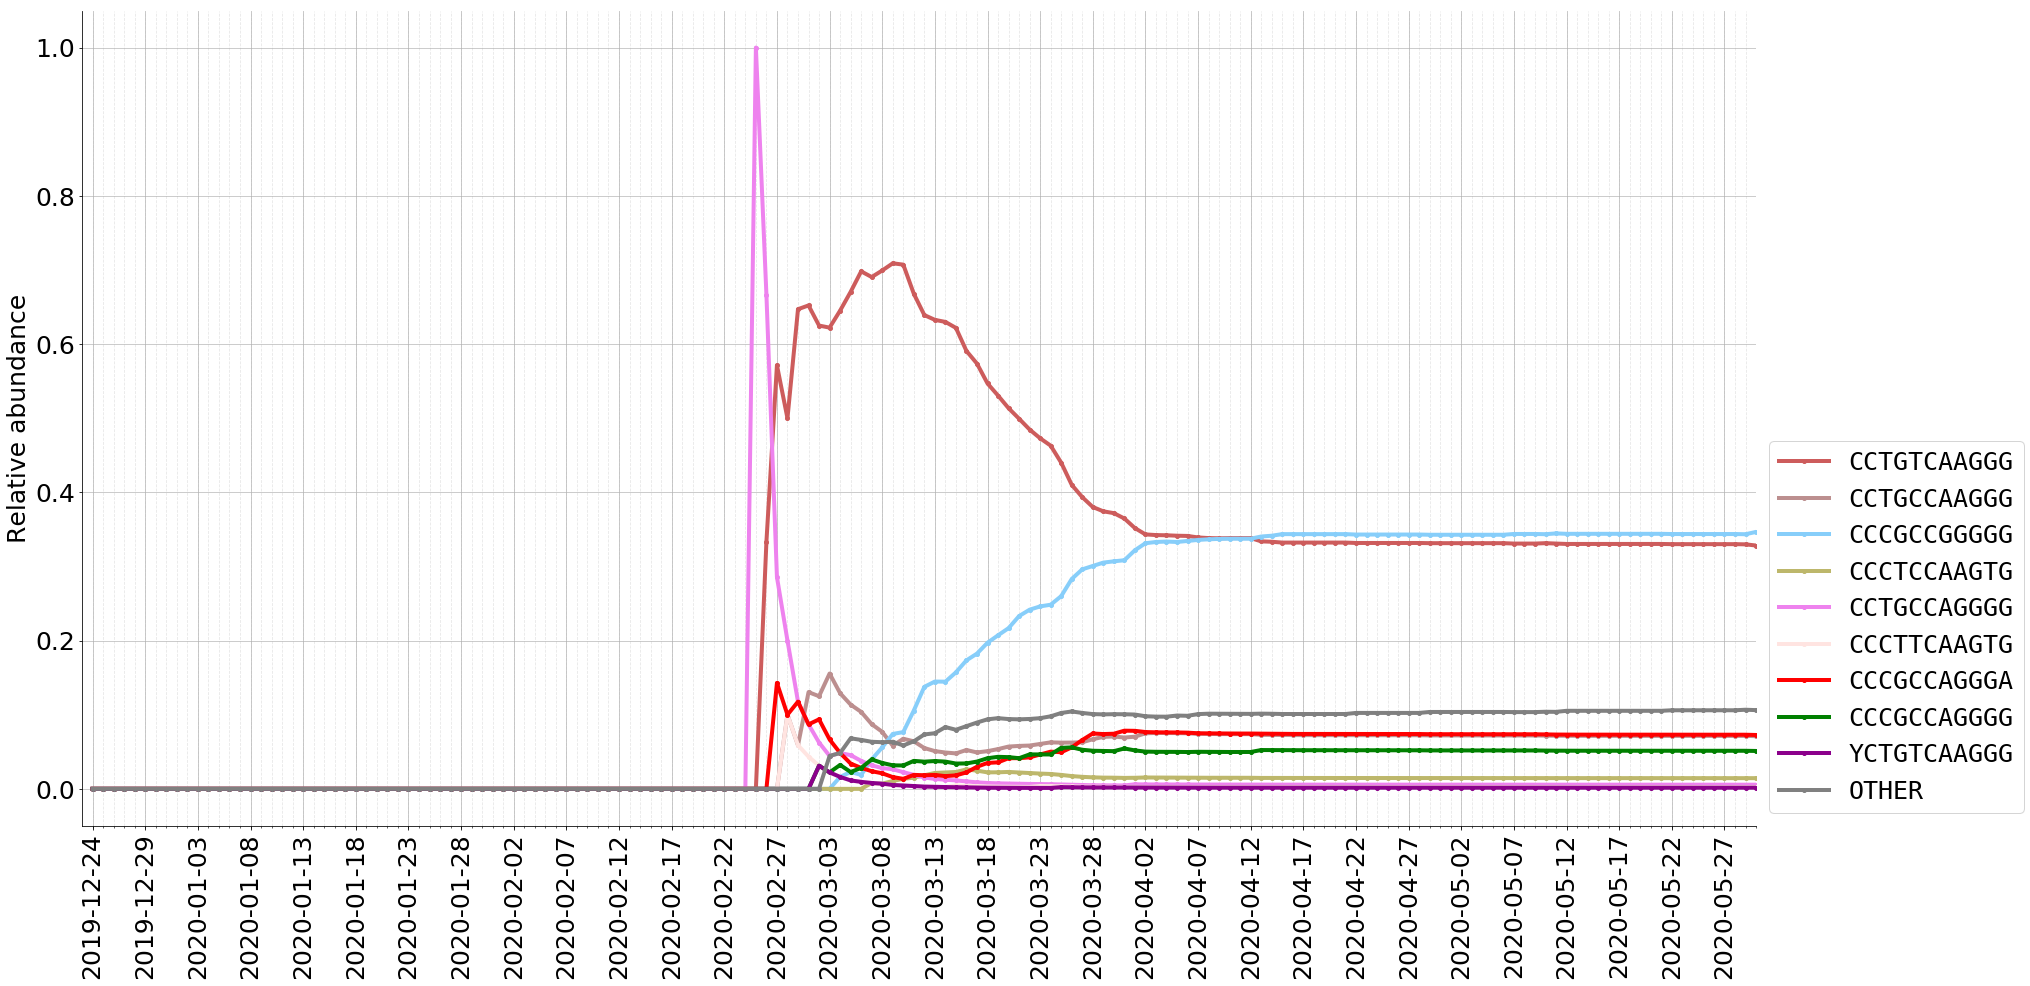

In [49]:
regional_growth_plot('Spain', ISM_df, REFERENCE_date, count_list, date_list)

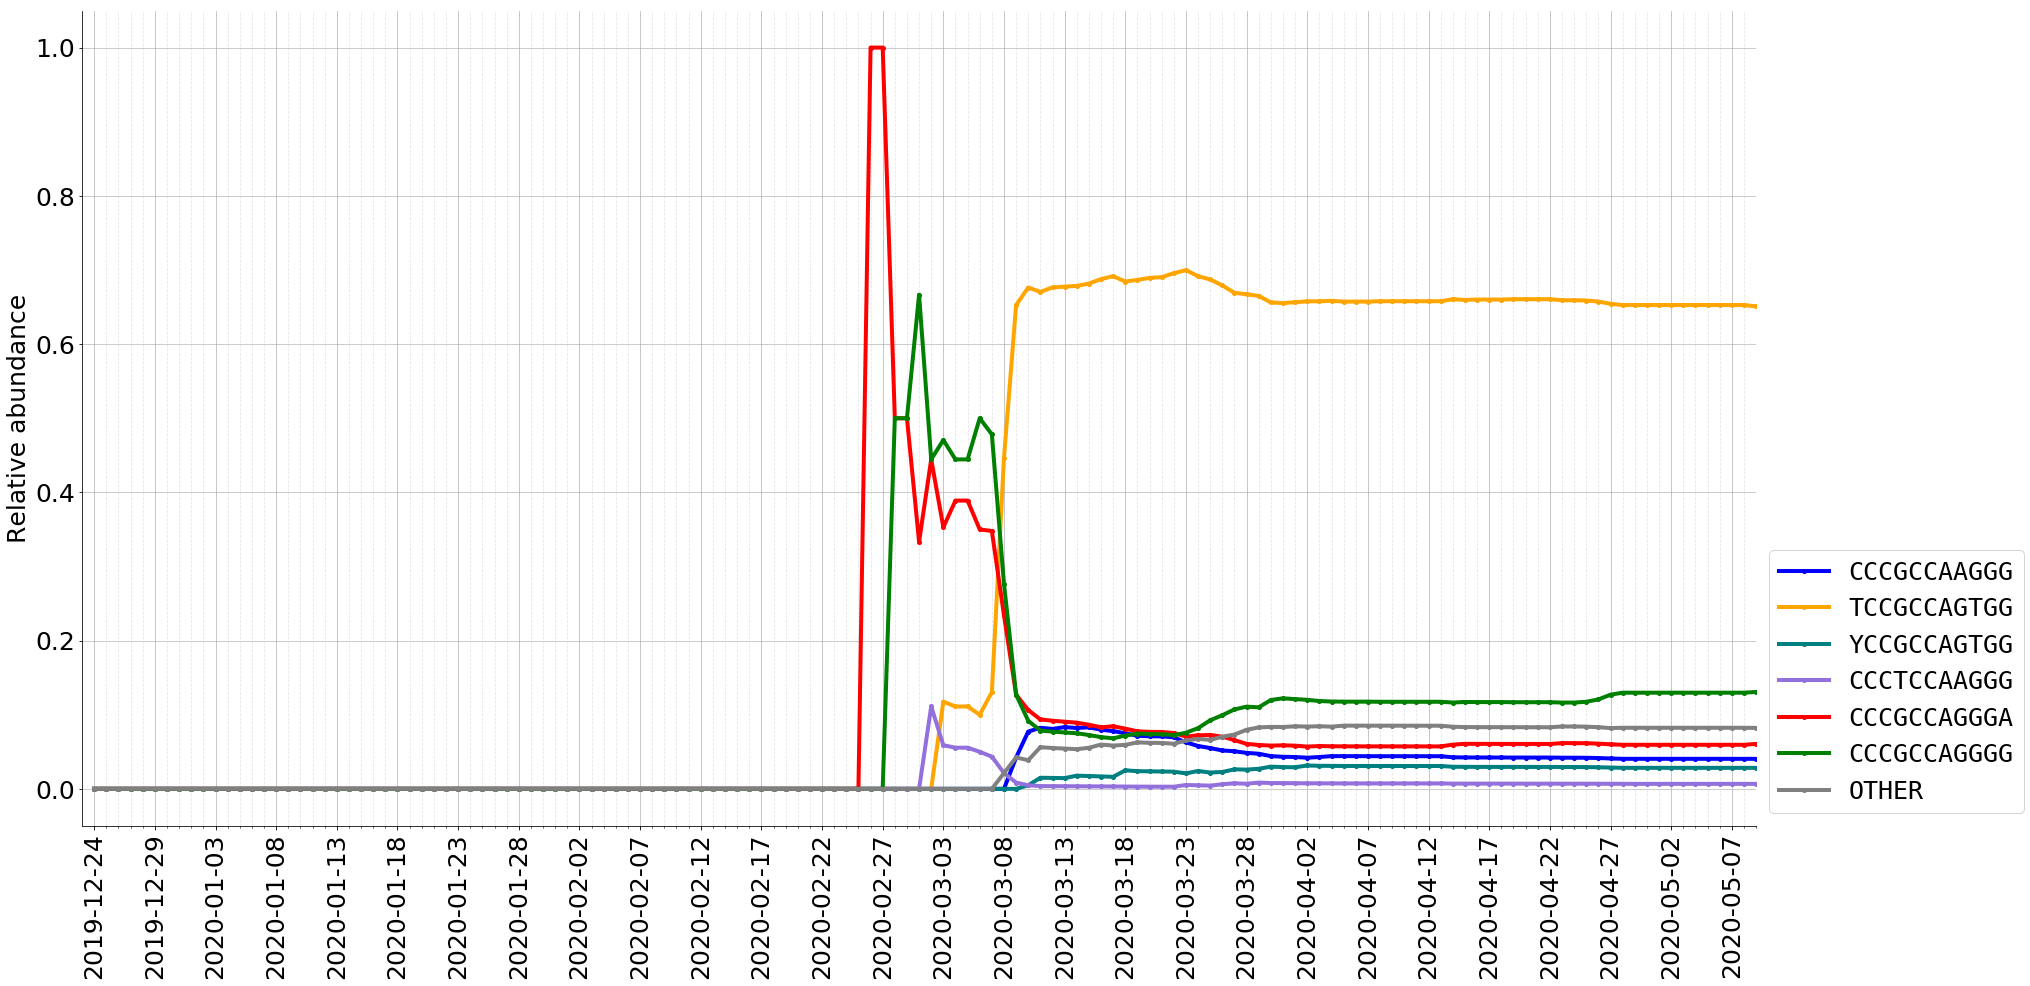

In [50]:
regional_growth_plot('Denmark', ISM_df, REFERENCE_date, count_list, date_list)

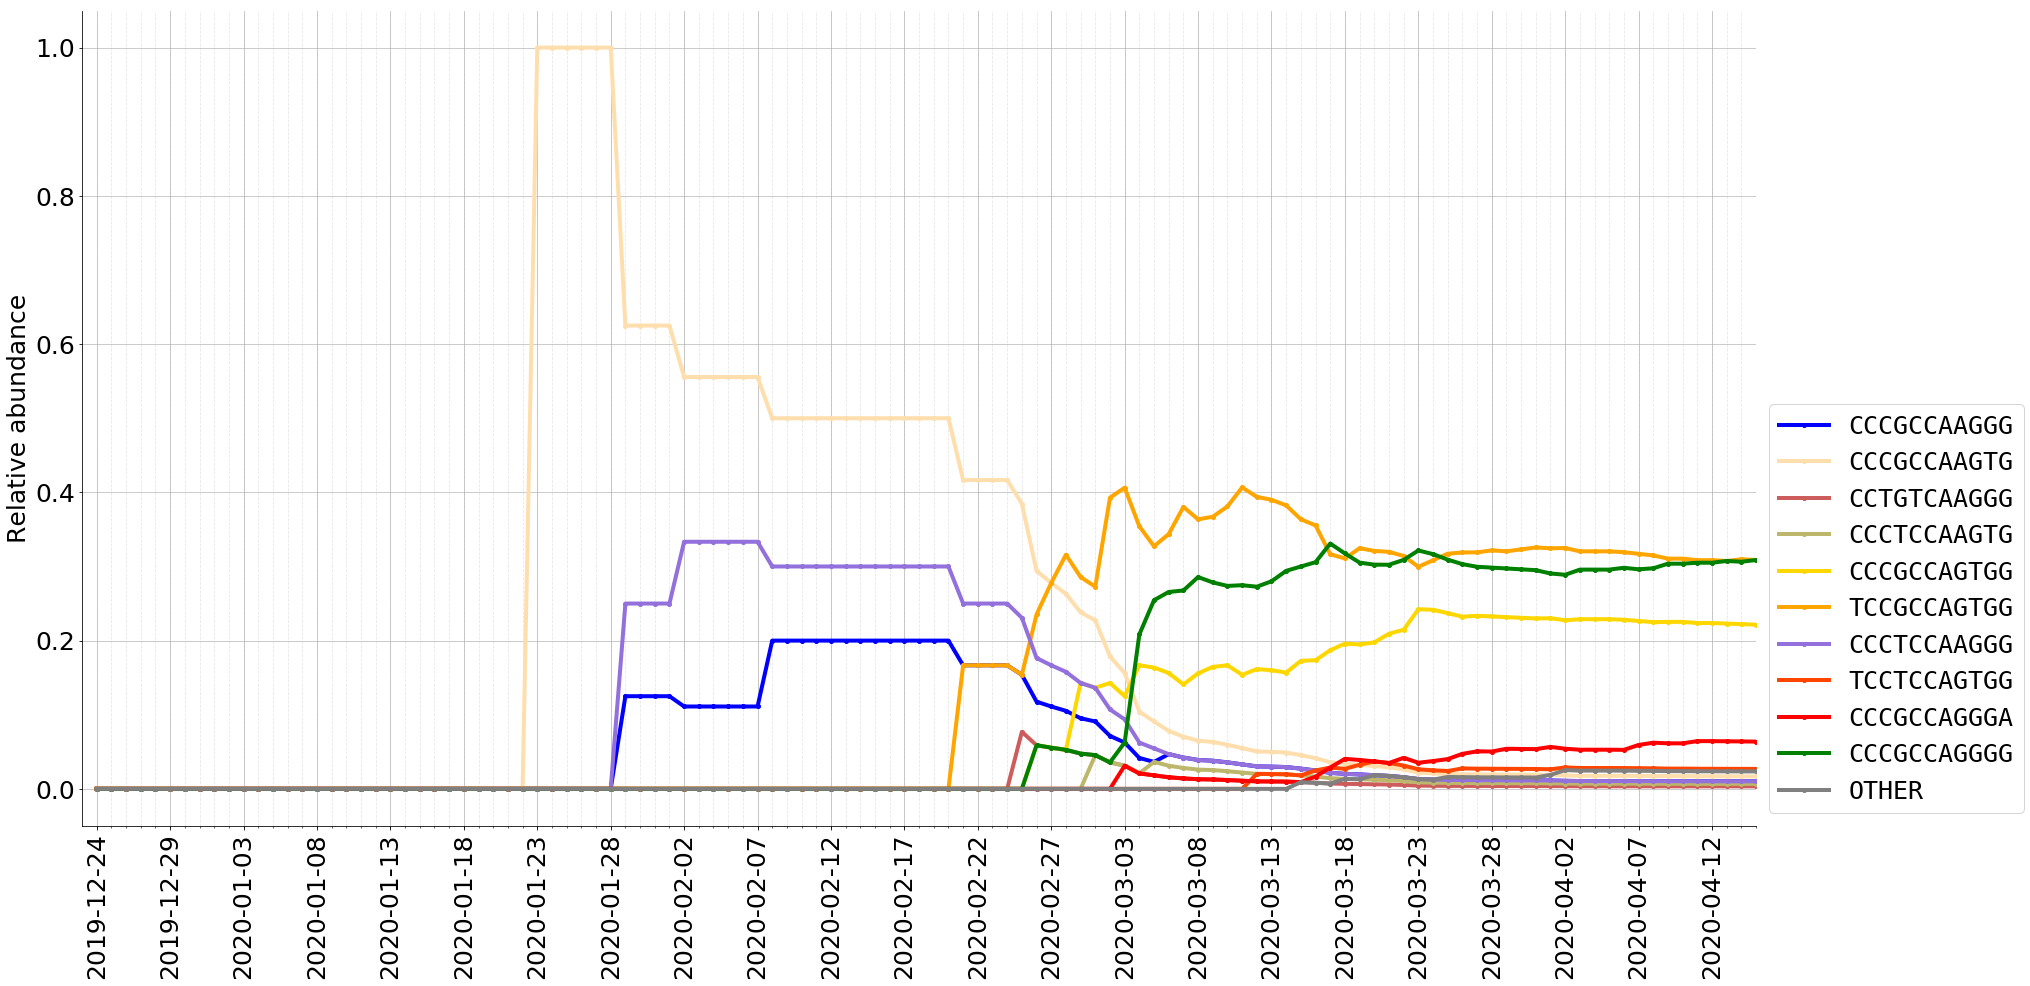

In [51]:
regional_growth_plot('France', ISM_df, REFERENCE_date, count_list, date_list)

In [68]:
font = {# 'family' : 'serif', # Times (source: https://matplotlib.org/tutorials/introductory/customizing.html)
        'family': 'sans-serif', # Helvetica
#         'family': 'monospace',
        'weight' : 'normal',
        'size'   : 9}
matplotlib.rc('font', **font) 
def typical_ISM_regional_growth(ISM, region, count_list, date_list):
    ISM_growth_list = []
    for i in range(len(count_list)):
        regional_dict_freq = count_list[i][region]
        if ISM in regional_dict_freq and regional_dict_freq[ISM][1] != 0:
            count = regional_dict_freq[ISM][1]
            freq = count/sum([regional_dict_freq[ISM][1] for ISM in regional_dict_freq])
        else:
            count, freq = 0, 0
        ISM_growth_list.append((count, freq))
        
    return ISM_growth_list

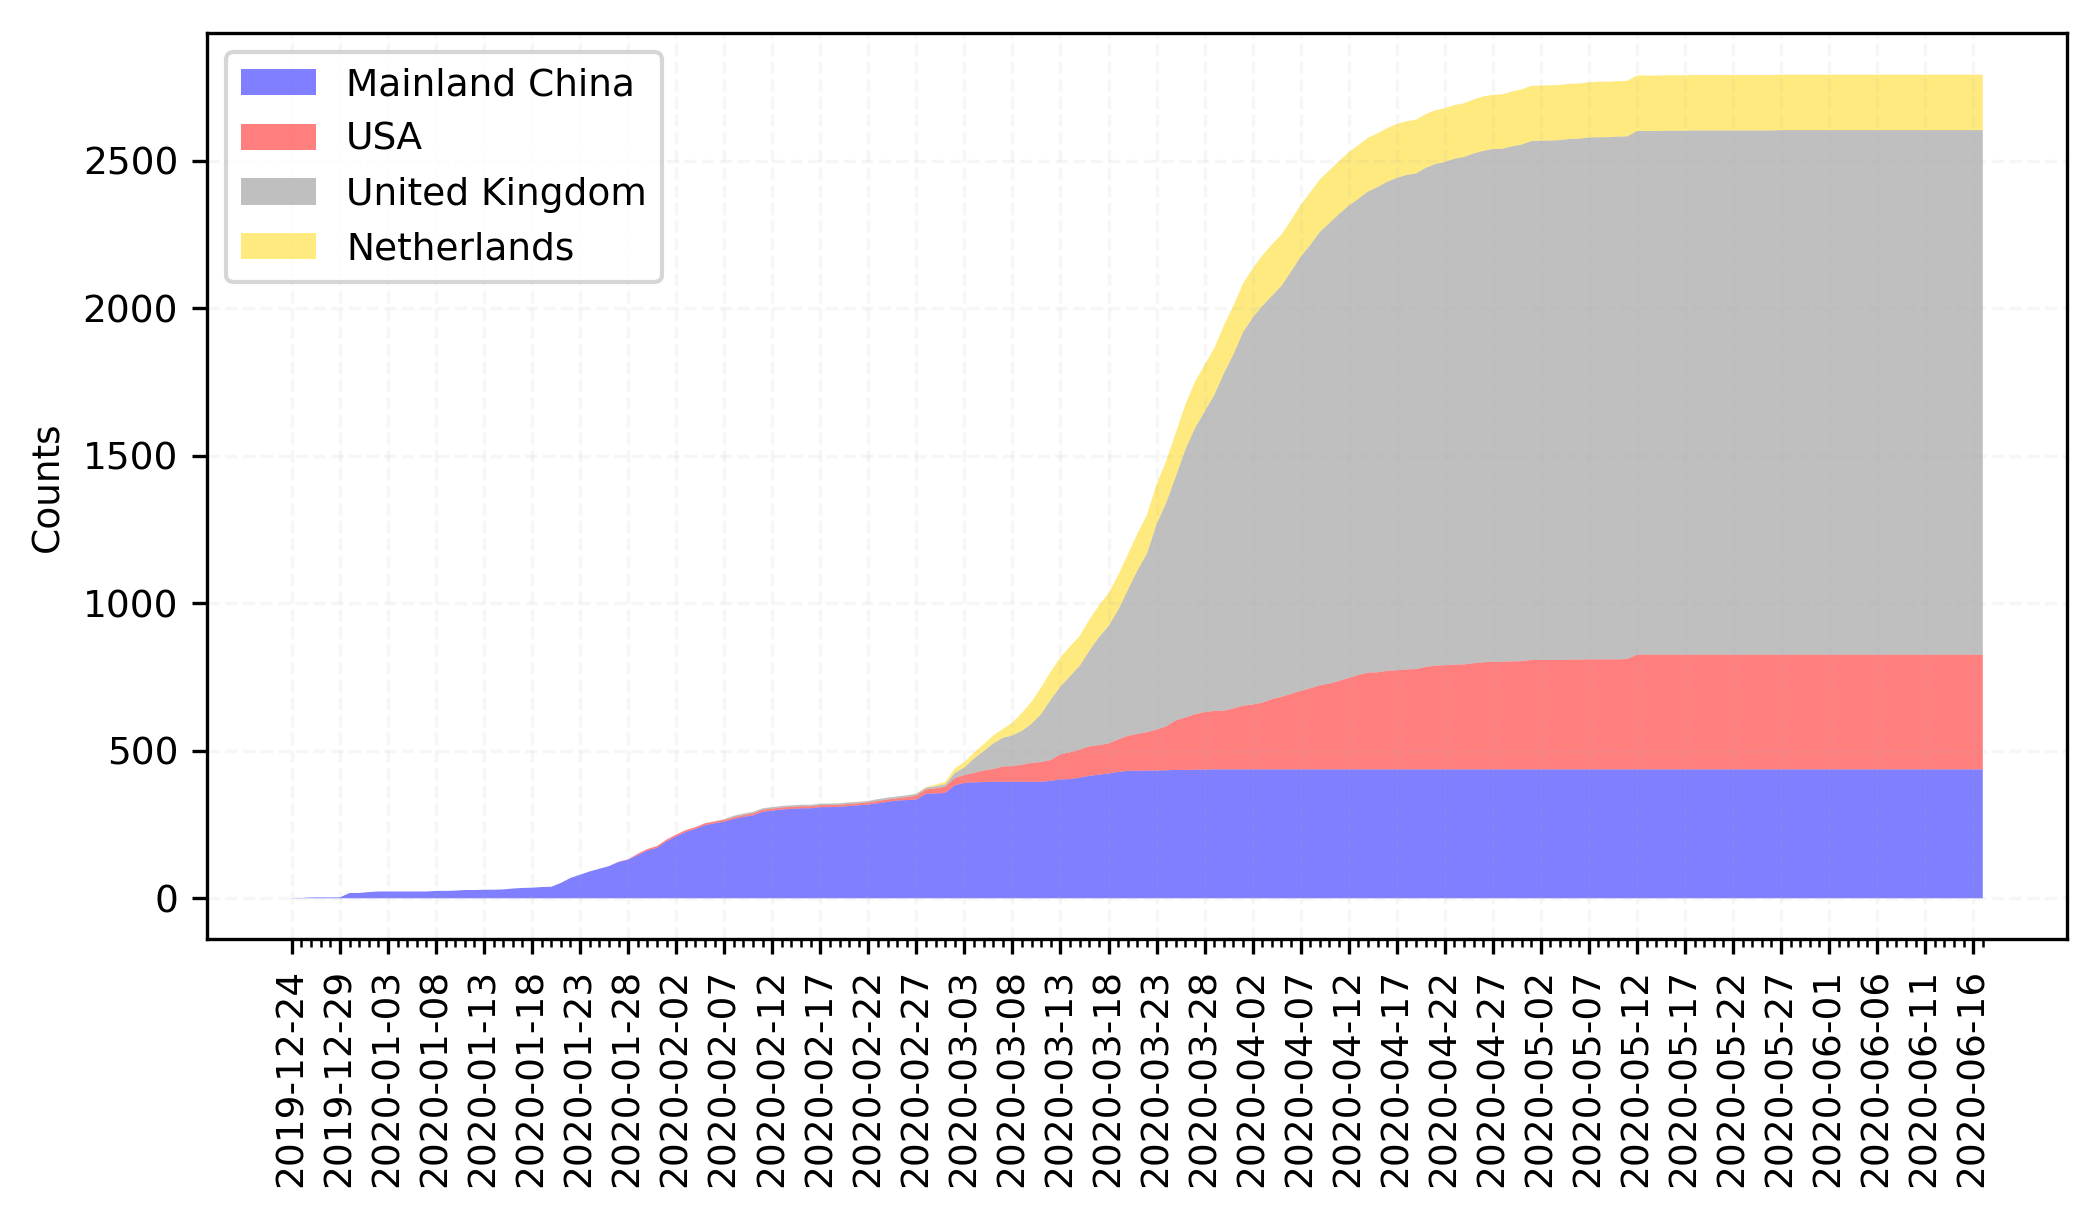

In [70]:
ISM = REFERENCE_ISM
y = []

region_list = ['Mainland China', 'USA', 'United Kingdom', 'Netherlands']
for region in region_list:
    ISM_growth_list = typical_ISM_regional_growth(ISM, region, count_list, date_list)
    y.append([item[0] for item in ISM_growth_list])

x = np.arange(len(y[0]))
y = np.row_stack(y)
y_stack = np.cumsum(y, axis=0)
fig = plt.figure(figsize=(2400/DPI, 1200/DPI), dpi=DPI)   
ax=plt.subplot(1, 1, 1)
n = 4
facecolor_list = ['blue', 'red', 'gray', 'gold']
for i in range(4):
    if i == 0:
        ax.fill_between(x, 0, y_stack[i,:], facecolor=facecolor_list[i], alpha=.5, label = region_list[i])
    else:
        ax.fill_between(x, y_stack[i-1], y_stack[i,:], facecolor=facecolor_list[i], alpha=.5, label = region_list[i])
major_ticks = np.arange(0, len(date_list), 5)
minor_ticks = np.arange(0, len(date_list))
major_label = []

for i in major_ticks.tolist():
    major_label.append(str(date_list[i]))
#     print(major_label)
ax.set_xticks(minor_ticks, minor=True)
ax.set_xticks(major_ticks)
ax.set_xticklabels(major_label)
# ax.grid(which='minor', alpha=0.1, linestyle='--')
ax.grid(which='major', alpha=0.1, linestyle='--')
ax.set_ylabel('Counts')
plt.setp(ax.get_xticklabels(), rotation=90)
plt.legend(loc='upper left')
plt.savefig('{}/9_typical_ISM_stack_plot_short.pdf'.format(output_folder), bbox_inches='tight', dpi=DPI)
plt.show()

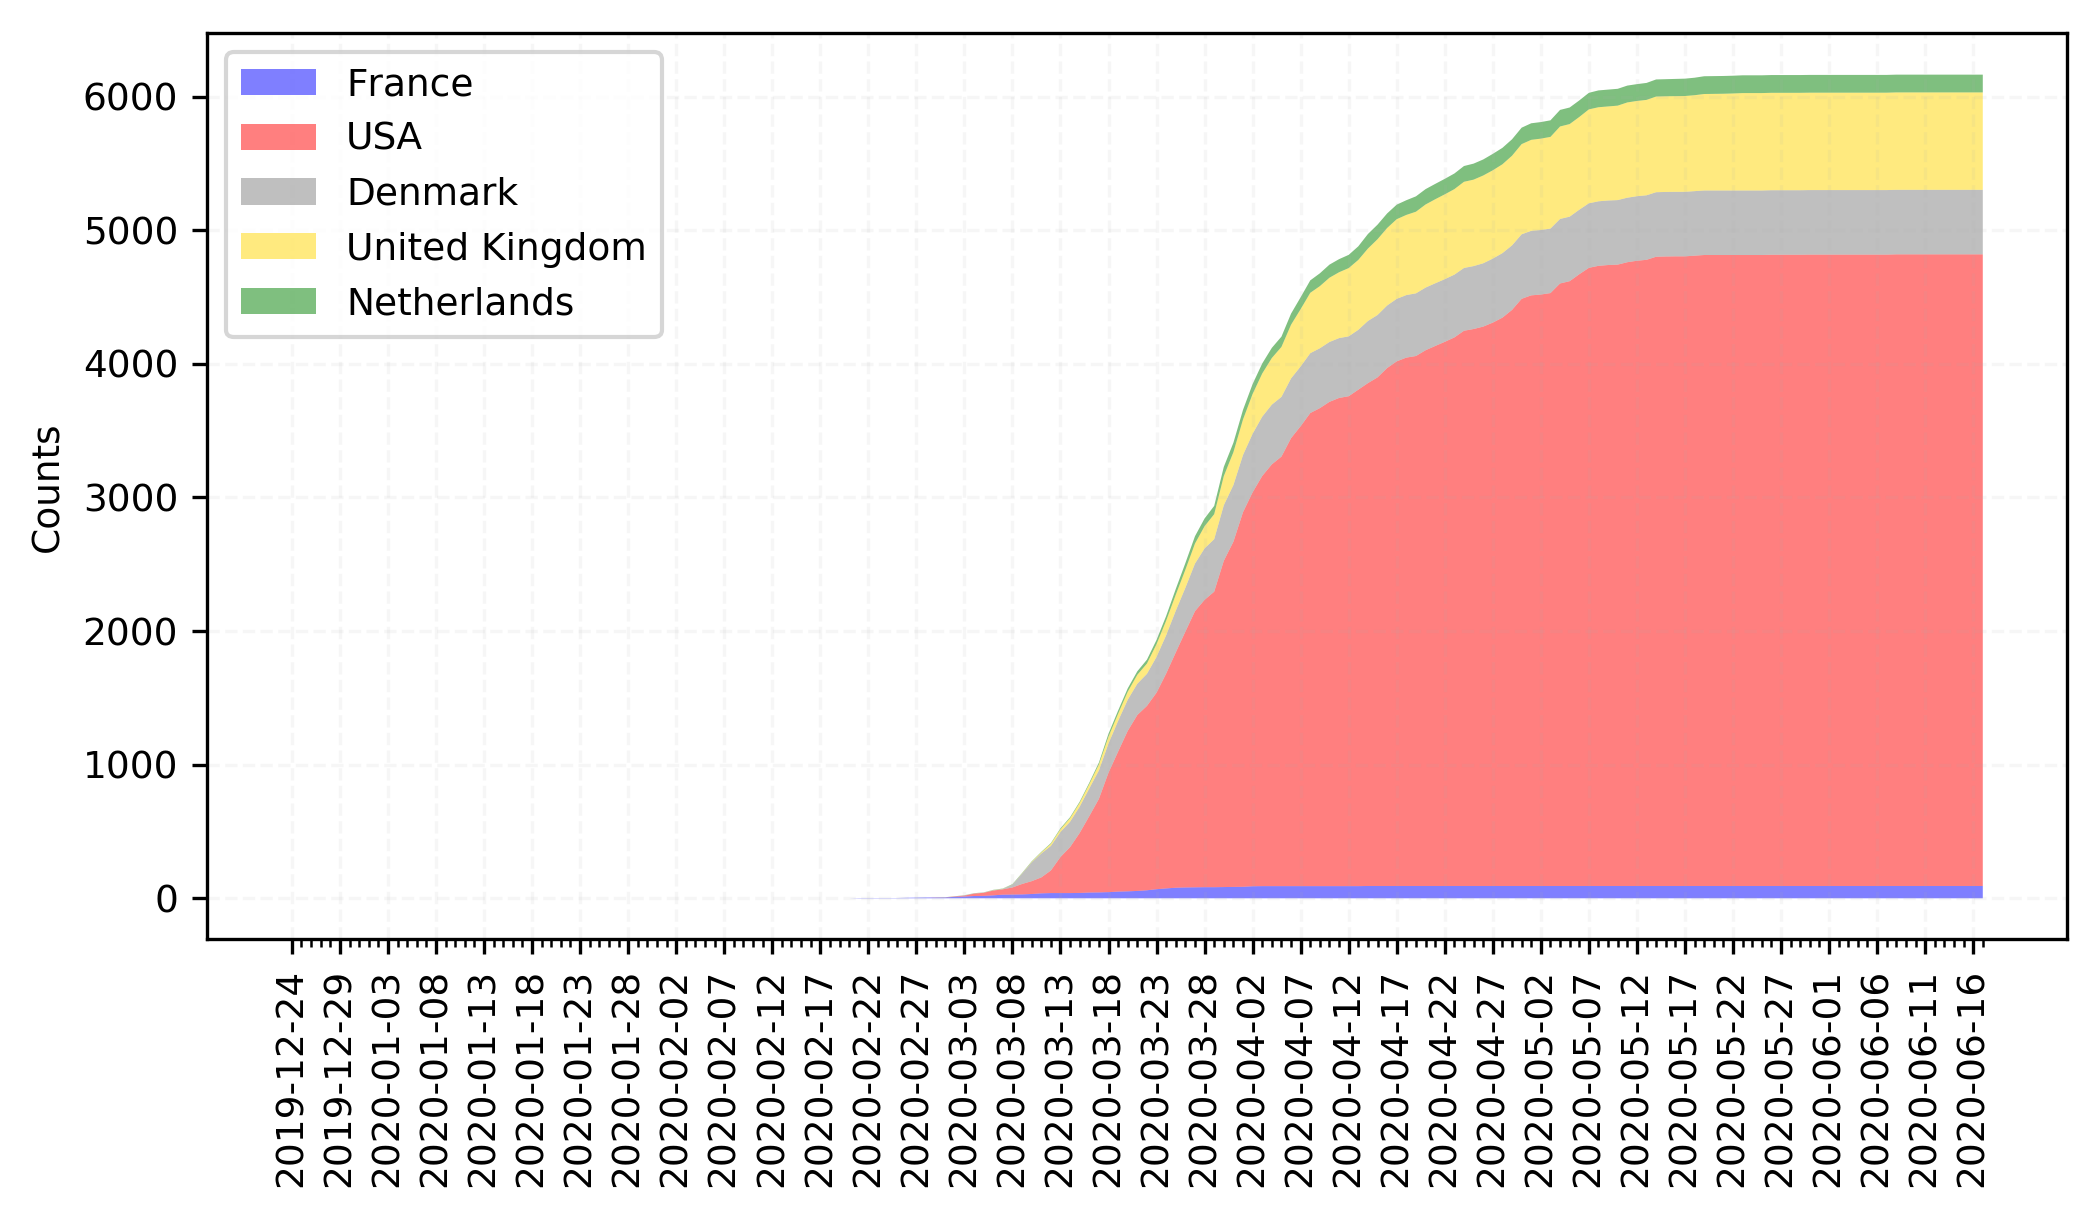

In [71]:
ISM = list(ISM_df[ISM_df['country/region'] == 'USA']['ISM'].value_counts()[:1].keys())[0]
y = []

region_list = ['France', 'USA', 'Denmark', 'United Kingdom', 'Netherlands']
for region in region_list:
    ISM_growth_list = typical_ISM_regional_growth(ISM, region, count_list, date_list)
    y.append([item[0] for item in ISM_growth_list])

x = np.arange(len(y[0]))
y = np.row_stack(y)
y_stack = np.cumsum(y, axis=0)
fig = plt.figure(figsize=(2400/DPI, 1200/DPI), dpi=DPI)   
ax=plt.subplot(1, 1, 1)
n = 4
facecolor_list = ['blue', 'red', 'gray', 'gold', 'green']
for i in range(5):
    if i == 0:
        ax.fill_between(x, 0, y_stack[i,:], facecolor=facecolor_list[i], alpha=.5, label = region_list[i])
    else:
        ax.fill_between(x, y_stack[i-1], y_stack[i,:], facecolor=facecolor_list[i], alpha=.5, label = region_list[i])
major_ticks = np.arange(0, len(date_list), 5)
minor_ticks = np.arange(0, len(date_list))
major_label = []

for i in major_ticks.tolist():
    major_label.append(str(date_list[i]))
#     print(major_label)
ax.set_xticks(minor_ticks, minor=True)
ax.set_xticks(major_ticks)
ax.set_xticklabels(major_label)
# ax.grid(which='minor', alpha=0.1, linestyle='--')
ax.grid(which='major', alpha=0.1, linestyle='--')
ax.set_ylabel('Counts')
plt.setp(ax.get_xticklabels(), rotation=90)
plt.legend(loc='upper left')
plt.savefig('{}/10_typical_ISM_stack_plot_short.pdf'.format(output_folder), bbox_inches='tight', dpi=DPI)
plt.show()